In [1]:
# basic imports
import os
import pandas as pd
import numpy as np
import datetime as dt
import random
import pandas_ta as ta
from pathlib import Path
#from tvDatafeed import TvDatafeed, Interval
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, auc, roc_curve, RocCurveDisplay
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# import boruta
from boruta import BorutaPy
import yfinance as yf
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Visualization 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')
import pydot
import graphviz
# SOM & Sklearn library
from minisom import MiniSom
from sklearn.cluster import KMeans
# Import VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
# tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 

from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.layers import LSTM, BatchNormalization,GRU

# kerastuner
import keras_tuner as kt
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import RandomSearch, BayesianOptimization, Hyperband

In [2]:

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 1000)

In [3]:
#ESF = yf.download("ES=F",start='2023-05-01',end='2025-03-31', interval='1h',progress=False)
#ESF.to_csv('D:/CloudxLab/ESF.csv')

In [4]:
df = pd.read_csv('D:/CloudxLab/ESF.csv', index_col=0, parse_dates=True)

In [5]:
df

,Close,High,Low,Open,Volume
Datetime,,,,,
2023-05-01 04:00:00+00:00,4191.50,4191.75,4190.00,4191.25,0
2023-05-01 05:00:00+00:00,4192.50,4194.75,4189.50,4191.50,4698
2023-05-01 06:00:00+00:00,4194.75,4196.00,4188.50,4192.25,6294
2023-05-01 07:00:00+00:00,4191.25,4195.00,4189.75,4194.75,6110
2023-05-01 08:00:00+00:00,4186.50,4191.25,4184.75,4191.00,7214
...,...,...,...,...,...
2025-03-30 23:00:00+00:00,5593.00,5594.75,5581.75,5594.50,17130
2025-03-31 00:00:00+00:00,5580.50,5593.75,5574.25,5592.75,23879
2025-03-31 01:00:00+00:00,5585.00,5592.25,5580.50,5580.75,14562


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,10933.0,5150.781967,627.354960,4068.75,4521.75,5205.50,5711.25,6165.25
High,10933.0,5155.834812,628.070349,4083.75,4525.25,5209.00,5716.75,6166.50
Low,10933.0,5145.182452,626.601260,4062.25,4517.50,5199.75,5706.25,6155.50
Open,10933.0,5150.715083,627.437186,4068.50,4521.50,5205.25,5712.00,6165.25
Volume,10933.0,63884.163542,94774.948605,0.00,6068.00,15296.00,102596.00,2091064.00


In [7]:
# check for missing values
df.isna().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [8]:
df.index = pd.to_datetime(df.index,utc= 'TRUE')

In [9]:
# add all factors
df.ta.study(ta.AllStrategy)
# AllStrategy = ta.AllStrategy
# print("name =", AllStrategy.name)
# print("description =", AllStrategy.description)
# print("created =", AllStrategy.created)
# print("ta =", AllStrategy.ta)
# df.ta.strategy(AllStrategy)

In [10]:
# copy dataframe
data = df.copy()

# define target (label)
data['predict'] = np.where(data['Close'].pct_change(-5) > 0, 1, 0)

# drop unwanted columns
data.drop(['HILOl_13_21', 'HILOs_13_21', 'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'PSARaf_0.02_0.2', 'QQEl_14_5_4.236', 'QQEs_14_5_4.236', 'SUPERTl_7_3.0', 'SUPERTs_7_3.0','VIDYA_14'], axis=1, inplace=True)
data = data[200:]

# backfill columns to address missing values
data = data.bfill(axis=1)
data = data[:-5] # to take care of 5day ahead prediction

# check last 5 rows
data.tail()

,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,ACCBL_20,ACCBM_20,ACCBU_20,AD,ADOSC_3_10,ADX_14,...,VTXM_14,VWAP_D,VWMA_10,TSV_18_10,TSVs_18_10,TSVr_18_10,WCP,WILLR_14,WMA_10,ZIGZAGs_5.0%_10,ZIGZAGv_5.0%_10,ZIGZAGd_5.0%_10,ZL_EMA_10,ZS_30,predict
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-03-28 17:00:00+00:00,5630.75,5633.00,5618.75,5632.00,174057.0,5661.333333,5680.177744,5642.488923,18.844410,5676.998297,5713.6375,5757.060797,3.030610e+07,-289516.717266,41.091296,...,1.405306,5672.262205,5661.292394,-24642615.50,-1.064921e+07,2.314032,5628.3125,-90.697674,5670.350000,5630.046629,5630.046629,5630.046629,5630.046629,-2.633574,1.0
2025-03-28 18:00:00+00:00,5628.75,5636.50,5619.75,5630.75,143085.0,5643.833333,5662.538116,5625.128550,18.704783,5669.975476,5708.0875,5752.725476,3.031678e+07,-242010.490013,42.999767,...,1.375986,5667.881518,5656.732734,-24970470.50,-1.296109e+07,1.926573,5628.4375,-92.248062,5659.177273,5624.947242,5624.947242,5624.947242,5624.947242,-2.345638,1.0
2025-03-28 19:00:00+00:00,5624.50,5634.25,5617.25,5628.75,295029.0,5634.483333,5653.074464,5615.892202,18.591131,5663.452339,5702.5125,5748.202339,3.027339e+07,-214380.003569,44.818261,...,1.375211,5660.624908,5650.222595,-26203976.75,-1.488171e+07,1.760817,5625.1250,-94.444444,5648.995455,5620.911379,5620.911379,5620.911379,5620.911379,-2.169653,1.0
2025-03-28 20:00:00+00:00,5602.50,5625.25,5602.25,5624.50,85426.0,5626.100000,5644.985055,5607.214945,18.885055,5656.280342,5695.5875,5743.280342,3.018982e+07,-210177.640213,46.766461,...,1.406639,5658.242543,5647.042187,-28105848.75,-1.746749e+07,1.609038,5608.1250,-99.818182,5636.631818,5612.200220,5612.200220,5612.200220,5612.200220,-2.342159,1.0
2025-03-30 22:00:00+00:00,5594.25,5600.00,5580.25,5590.00,22300.0,5616.533333,5635.642718,5597.423948,19.109385,5647.083490,5688.4000,5737.458490,3.019914e+07,-186387.509316,48.882431,...,1.432119,5591.500000,5645.744790,-28299001.50,-2.028136e+07,1.395321,5592.1875,-91.222571,5625.177273,5602.300180,5602.300180,5602.300180,5602.300180,-2.249456,1.0


In [11]:
# check for missing values
data.isna().sum()

Close                           0
High                            0
Low                             0
Open                            0
Volume                          0
ABER_ZG_5_15                    0
ABER_SG_5_15                    0
ABER_XG_5_15                    0
ABER_ATR_5_15                   0
ACCBL_20                        0
ACCBM_20                        0
ACCBU_20                        0
AD                              0
ADOSC_3_10                      0
ADX_14                          0
ADXR_14_2                       0
DMP_14                          0
DMN_14                          0
AGj_13_8_5                      0
AGt_13_8_5                      0
AGl_13_8_5                      0
ALMA_9_6.0_0.85                 0
ALPHAT_14_1_50                  0
ALPHATl_14_1_50_2               0
AMATe_LR_8_21_2                 0
AMATe_SR_8_21_2                 0
AO_5_34                         0
OBV                             0
OBV_min_2                       0
OBV_max_2     

In [12]:
data.mean()

Close                           5.169401e+03
High                            5.174461e+03
Low                             5.163787e+03
Open                            5.169329e+03
Volume                          6.388173e+04
ABER_ZG_5_15                    5.168943e+03
ABER_SG_5_15                    5.179725e+03
ABER_XG_5_15                    5.158161e+03
ABER_ATR_5_15                   1.078200e+01
ACCBL_20                        5.141156e+03
ACCBM_20                        5.168063e+03
ACCBU_20                        5.194484e+03
AD                              1.698248e+07
ADOSC_3_10                      9.991163e+03
ADX_14                          2.842791e+01
ADXR_14_2                       2.842565e+01
DMP_14                          3.140142e+01
DMN_14                          3.353531e+01
AGj_13_8_5                      5.167682e+03
AGt_13_8_5                      5.168414e+03
AGl_13_8_5                      5.168845e+03
ALMA_9_6.0_0.85                 5.169107e+03
ALPHAT_14_

In [13]:
# class frequency
c = data['predict'].value_counts()
c

predict
0.0    5883
1.0    4845
Name: count, dtype: int64

In [14]:
# class weight function
def cwts(dfs):
    c0, c1 = np.bincount(dfs['predict'])
    w0=(1/c0)*(len(df))/2 
    w1=(1/c1)*(len(df))/2 
    return {0: w0, 1: w1}

In [15]:
# check class weights
class_weight = cwts(data)
class_weight

{0: 0.9292027876933537, 1: 1.1282765737874096}

In [16]:
# With the calculated weights, both classes gain equal weight
class_weight[0] * c[0], class_weight[1] * c[1]

(5466.5, 5466.5)

In [17]:
X = data.drop(['predict'], axis=1)
feature_names = X.columns
X.tail()

,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,ACCBL_20,ACCBM_20,ACCBU_20,AD,ADOSC_3_10,ADX_14,...,VTXP_14,VTXM_14,VWAP_D,VWMA_10,TSV_18_10,TSVs_18_10,TSVr_18_10,WCP,WILLR_14,WMA_10,ZIGZAGs_5.0%_10,ZIGZAGv_5.0%_10,ZIGZAGd_5.0%_10,ZL_EMA_10,ZS_30
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-03-28 17:00:00+00:00,5630.75,5633.00,5618.75,5632.00,174057.0,5661.333333,5680.177744,5642.488923,18.844410,5676.998297,5713.6375,5757.060797,3.030610e+07,-289516.717266,41.091296,...,0.553522,1.405306,5672.262205,5661.292394,-24642615.50,-1.064921e+07,2.314032,5628.3125,-90.697674,5670.350000,5630.046629,5630.046629,5630.046629,5630.046629,-2.633574
2025-03-28 18:00:00+00:00,5628.75,5636.50,5619.75,5630.75,143085.0,5643.833333,5662.538116,5625.128550,18.704783,5669.975476,5708.0875,5752.725476,3.031678e+07,-242010.490013,42.999767,...,0.578440,1.375986,5667.881518,5656.732734,-24970470.50,-1.296109e+07,1.926573,5628.4375,-92.248062,5659.177273,5624.947242,5624.947242,5624.947242,5624.947242,-2.345638
2025-03-28 19:00:00+00:00,5624.50,5634.25,5617.25,5628.75,295029.0,5634.483333,5653.074464,5615.892202,18.591131,5663.452339,5702.5125,5748.202339,3.027339e+07,-214380.003569,44.818261,...,0.586847,1.375211,5660.624908,5650.222595,-26203976.75,-1.488171e+07,1.760817,5625.1250,-94.444444,5648.995455,5620.911379,5620.911379,5620.911379,5620.911379,-2.169653
2025-03-28 20:00:00+00:00,5602.50,5625.25,5602.25,5624.50,85426.0,5626.100000,5644.985055,5607.214945,18.885055,5656.280342,5695.5875,5743.280342,3.018982e+07,-210177.640213,46.766461,...,0.577593,1.406639,5658.242543,5647.042187,-28105848.75,-1.746749e+07,1.609038,5608.1250,-99.818182,5636.631818,5612.200220,5612.200220,5612.200220,5612.200220,-2.342159
2025-03-30 22:00:00+00:00,5594.25,5600.00,5580.25,5590.00,22300.0,5616.533333,5635.642718,5597.423948,19.109385,5647.083490,5688.4000,5737.458490,3.019914e+07,-186387.509316,48.882431,...,0.572020,1.432119,5591.500000,5645.744790,-28299001.50,-2.028136e+07,1.395321,5592.1875,-91.222571,5625.177273,5602.300180,5602.300180,5602.300180,5602.300180,-2.249456


In [18]:
y = data['predict'].values
# pandas-ta converts all dtype to objects
y = y.astype(int) 
y

array([0, 0, 0, ..., 1, 1, 1])

In [19]:
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# convert to array
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test) 

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 8582, 2146


In [20]:
# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, 
                                class_weight=cwts(data), 
                                random_state=42, 
                                max_depth=5)

# train the model
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.9292027876933537,
                                     1: 1.1282765737874096},
                       max_depth=5, n_jobs=-1, random_state=42)

In [21]:
# print scores
print("Accuracy Score \t\t", accuracy_score(y_test, forest.predict(X_test)))

Accuracy Score 		 0.6584342963653308


In [22]:
# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=0,max_iter=300)

# find all relevant features
# takes input in array format not as dataframe
feat_selector.fit(X_train, y_train)

Iteration: 	1 / 300
Confirmed: 	0
Tentative: 	330
Rejected: 	0
Iteration: 	2 / 300
Confirmed: 	0
Tentative: 	330
Rejected: 	0
Iteration: 	3 / 300
Confirmed: 	0
Tentative: 	330
Rejected: 	0
Iteration: 	4 / 300
Confirmed: 	0
Tentative: 	330
Rejected: 	0
Iteration: 	5 / 300
Confirmed: 	0
Tentative: 	330
Rejected: 	0
Iteration: 	6 / 300
Confirmed: 	0
Tentative: 	330
Rejected: 	0
Iteration: 	7 / 300
Confirmed: 	0
Tentative: 	330
Rejected: 	0
Iteration: 	8 / 300
Confirmed: 	0
Tentative: 	100
Rejected: 	230
Iteration: 	9 / 300
Confirmed: 	15
Tentative: 	85
Rejected: 	230
Iteration: 	10 / 300
Confirmed: 	15
Tentative: 	85
Rejected: 	230
Iteration: 	11 / 300
Confirmed: 	15
Tentative: 	85
Rejected: 	230
Iteration: 	12 / 300
Confirmed: 	19
Tentative: 	81
Rejected: 	230
Iteration: 	13 / 300
Confirmed: 	19
Tentative: 	81
Rejected: 	230
Iteration: 	14 / 300
Confirmed: 	19
Tentative: 	81
Rejected: 	230
Iteration: 	15 / 300
Confirmed: 	19
Tentative: 	81
Rejected: 	230
Iteration: 	16 / 300
Confirmed: 	

BorutaPy(estimator=RandomForestClassifier(class_weight={0: 0.9292027876933537,
                                                        1: 1.1282765737874096},
                                          max_depth=5, n_estimators=278,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x278A5423E40),
         max_iter=300, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x278A5423E40, verbose=2)

In [23]:
# check selected features
print(feat_selector.support_)

# check ranking of features
print(feat_selector.ranking_)

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_train)

[ True False False False False False False False False False False  True
  True False False False  True False False False False False False False
 False False  True  True  True  True  True  True False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True False False False False
 False False False False  True False False False False False False False
 False False False False False  True False  True False False False False
  True False False False  True  True False False False False False False
  True  True False False False False  True False Fa

In [24]:
X_filtered_1 = feat_selector.transform(X_train)
X_filtered_1

array([[ 4.14400000e+03,  4.17664414e+03,  1.39104718e+05, ...,
        -5.21276596e+01,  4.14147682e+03, -4.24333591e-01],
       [ 4.14525000e+03,  4.17558141e+03,  1.87401607e+05, ...,
        -4.94680851e+01,  4.14275376e+03, -3.10069899e-01],
       [ 4.14875000e+03,  4.17485645e+03,  1.87401607e+05, ...,
        -4.20212766e+01,  4.14629853e+03, -6.48597483e-02],
       ...,
       [ 6.00150000e+03,  6.01028058e+03,  2.73676365e+07, ...,
        -2.50000000e+01,  6.00505460e+03,  1.20677558e+00],
       [ 6.00300000e+03,  6.01165541e+03,  2.73679600e+07, ...,
        -2.17391304e+01,  6.00390831e+03,  1.20713580e+00],
       [ 6.00300000e+03,  6.01292982e+03,  2.73667319e+07, ...,
        -2.38095238e+01,  6.00360680e+03,  1.13045115e+00]])

In [25]:
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(feature_names, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print(f'Feature: {feat[0]:<30} Rank: {feat[1]:<5} Keep: {feat[2]}')

Feature: Close                          Rank: 1     Keep: True
Feature: High                           Rank: 25    Keep: False
Feature: Low                            Rank: 85    Keep: False
Feature: Open                           Rank: 106   Keep: False
Feature: Volume                         Rank: 135   Keep: False
Feature: ABER_ZG_5_15                   Rank: 94    Keep: False
Feature: ABER_SG_5_15                   Rank: 79    Keep: False
Feature: ABER_XG_5_15                   Rank: 81    Keep: False
Feature: ABER_ATR_5_15                  Rank: 2     Keep: False
Feature: ACCBL_20                       Rank: 117   Keep: False
Feature: ACCBM_20                       Rank: 110   Keep: False
Feature: ACCBU_20                       Rank: 1     Keep: True
Feature: AD                             Rank: 1     Keep: True
Feature: ADOSC_3_10                     Rank: 2     Keep: False
Feature: ADX_14                         Rank: 2     Keep: False
Feature: ADXR_14_2                      Ran

In [26]:
selected_rf_features = pd.DataFrame({'Feature':feature_names,
                                     'Ranking':feat_selector.ranking_})

# selected_rf_features#.sort_values(by='Ranking') 

selected_rf_features[selected_rf_features['Ranking']==1]

,Feature,Ranking
0,Close,1
11,ACCBU_20,1
12,AD,1
16,DMP_14,1
26,AO_5_34,1
27,OBV,1
28,OBV_min_2,1
29,OBV_max_2,1
30,OBVe_4,1
31,OBVe_12,1


In [27]:
sel=selected_rf_features[selected_rf_features['Ranking']==1]

In [28]:
# check the shape 
X_filtered.shape

(8582, 78)

In [29]:
# fit with selected features
forest.fit(X_filtered, y_train)

RandomForestClassifier(class_weight={0: 0.9292027876933537,
                                     1: 1.1282765737874096},
                       max_depth=5, n_estimators=278, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x278A5423E40)

In [30]:
# first apply feature selector transform to make sure same features are selected
X_test_filtered = feat_selector.transform(X_test)
X_test_filtered

array([[ 6.00750000e+03,  6.01424149e+03,  2.73681949e+07, ...,
        -1.89655172e+01,  6.00472374e+03,  1.27708205e+00],
       [ 6.00500000e+03,  6.01574116e+03,  2.73672797e+07, ...,
        -2.90909091e+01,  6.00541034e+03,  1.07586006e+00],
       [ 6.00850000e+03,  6.01786633e+03,  2.73701054e+07, ...,
        -1.63636364e+01,  6.00697209e+03,  1.19799641e+00],
       ...,
       [ 5.62450000e+03,  5.74820234e+03,  3.02733928e+07, ...,
        -9.44444444e+01,  5.62091138e+03, -2.16965323e+00],
       [ 5.60250000e+03,  5.74328034e+03,  3.01898239e+07, ...,
        -9.98181818e+01,  5.61220022e+03, -2.34215925e+00],
       [ 5.59425000e+03,  5.73745849e+03,  3.01991391e+07, ...,
        -9.12225705e+01,  5.60230018e+03, -2.24945644e+00]])

In [31]:
# check the shape
X_test_filtered.shape

(2146, 78)

In [32]:
# predict labels with unseen dataset
prediction = forest.predict(X_test_filtered)

In [33]:
# print scores
print("Accuracy Score \t\t", accuracy_score(y_test, prediction))

Accuracy Score 		 0.7050326188257223


In [34]:
# Classification Report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.67      0.86      0.75      1138
           1       0.77      0.53      0.63      1008

    accuracy                           0.71      2146
   macro avg       0.72      0.70      0.69      2146
weighted avg       0.72      0.71      0.70      2146



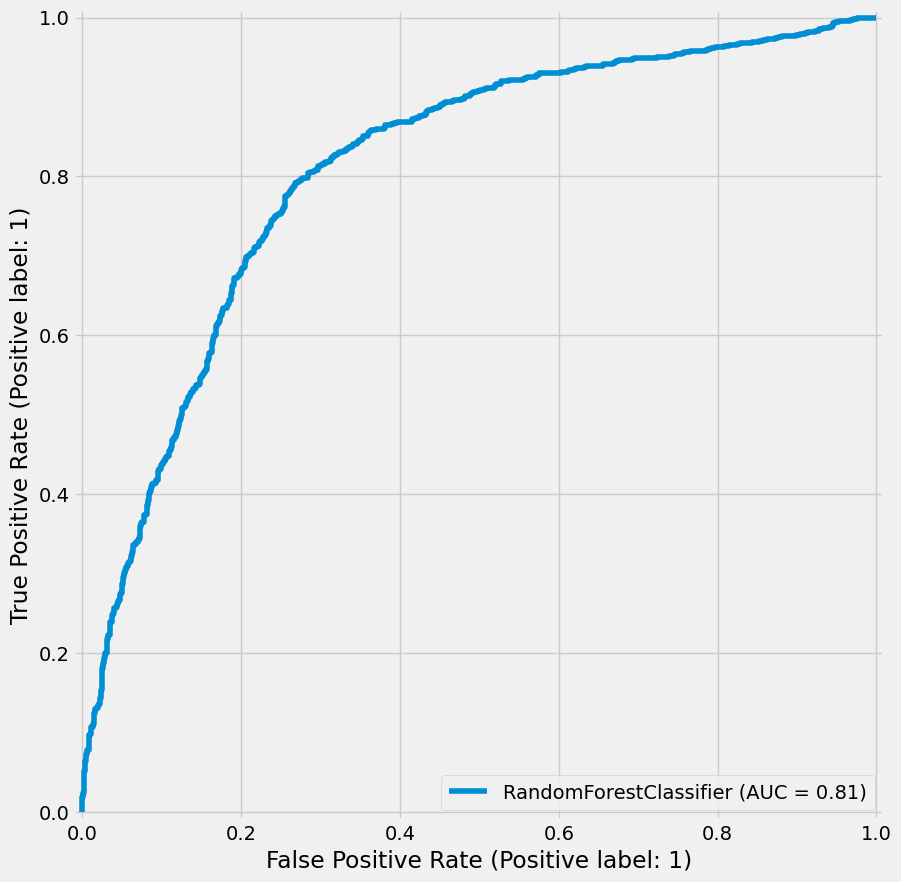

In [35]:
# plot roc
RocCurveDisplay.from_estimator(forest, X_test_filtered, y_test);

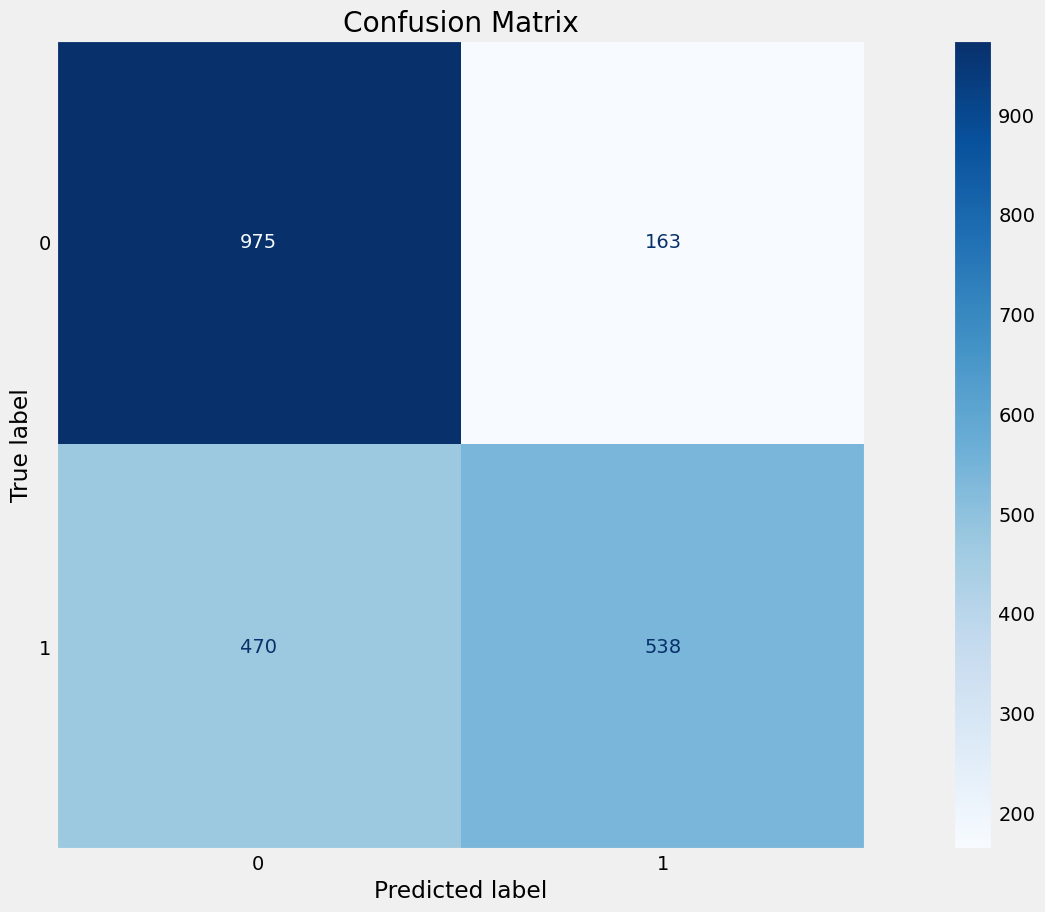

In [36]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(forest, X_test_filtered, y_test, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

In [37]:
X

,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,ACCBL_20,ACCBM_20,ACCBU_20,AD,ADOSC_3_10,ADX_14,...,VTXP_14,VTXM_14,VWAP_D,VWMA_10,TSV_18_10,TSVs_18_10,TSVr_18_10,WCP,WILLR_14,WMA_10,ZIGZAGs_5.0%_10,ZIGZAGv_5.0%_10,ZIGZAGd_5.0%_10,ZL_EMA_10,ZS_30
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-11 19:00:00+00:00,4144.00,4145.50,4136.50,4144.50,177477.0,4139.066667,4150.536503,4127.596830,11.469837,4127.519138,4151.7375,4176.644138,1.391047e+05,133049.775078,23.121759,...,0.867244,1.105339,4139.411662,4137.969551,-2076637.00,-5.570004e+05,3.728251,4142.5000,-52.127660,4140.572727,4141.476818,4141.476818,4141.476818,4141.476818,-0.424334
2023-05-11 20:00:00+00:00,4145.25,4145.75,4141.25,4144.00,62096.0,4140.300000,4151.305181,4129.294819,11.005181,4126.893913,4150.9125,4175.581413,1.874016e+05,153792.518856,22.782025,...,0.909884,1.097384,4139.616049,4138.089410,-2002493.25,-1.086842e+06,1.842487,4144.3750,-49.468085,4141.177273,4142.753760,4142.753760,4142.753760,4142.753760,-0.310070
2023-05-11 22:00:00+00:00,4148.75,4149.50,4143.75,4144.50,0.0,4141.716667,4152.371502,4131.061831,10.654835,4126.106448,4150.3750,4174.856448,1.874016e+05,148297.048687,21.977115,...,0.920420,1.112613,4139.616049,4137.872708,-2002493.25,-1.690910e+06,1.184269,4147.6875,-42.021277,4142.659091,4146.298531,4146.298531,4146.298531,4146.298531,-0.064860
2023-05-11 23:00:00+00:00,4146.00,4148.75,4146.00,4148.50,2912.0,4144.250000,4154.377846,4134.122154,10.127846,4125.481448,4149.6625,4174.231448,1.844896e+05,131640.806465,21.229698,...,0.901840,1.119632,4139.630997,4137.302401,-2015179.75,-2.404742e+06,0.838002,4146.6875,-47.872340,4143.604545,4146.471526,4146.471526,4146.471526,4146.471526,-0.321340
2023-05-12 00:00:00+00:00,4151.50,4152.00,4145.25,4145.75,8327.0,4145.983333,4155.885990,4136.080677,9.902657,4124.269449,4149.2250,4174.206949,1.915830e+05,115116.524631,20.097679,...,0.901538,1.101538,4149.583333,4140.376301,-1973241.50,-2.286844e+06,0.862867,4150.0625,-32.960894,4145.577273,4148.749430,4148.749430,4148.749430,4148.749430,0.101855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-28 17:00:00+00:00,5630.75,5633.00,5618.75,5632.00,174057.0,5661.333333,5680.177744,5642.488923,18.844410,5676.998297,5713.6375,5757.060797,3.030610e+07,-289516.717266,41.091296,...,0.553522,1.405306,5672.262205,5661.292394,-24642615.50,-1.064921e+07,2.314032,5628.3125,-90.697674,5670.350000,5630.046629,5630.046629,5630.046629,5630.046629,-2.633574
2025-03-28 18:00:00+00:00,5628.75,5636.50,5619.75,5630.75,143085.0,5643.833333,5662.538116,5625.128550,18.704783,5669.975476,5708.0875,5752.725476,3.031678e+07,-242010.490013,42.999767,...,0.578440,1.375986,5667.881518,5656.732734,-24970470.50,-1.296109e+07,1.926573,5628.4375,-92.248062,5659.177273,5624.947242,5624.947242,5624.947242,5624.947242,-2.345638
2025-03-28 19:00:00+00:00,5624.50,5634.25,5617.25,5628.75,295029.0,5634.483333,5653.074464,5615.892202,18.591131,5663.452339,5702.5125,5748.202339,3.027339e+07,-214380.003569,44.818261,...,0.586847,1.375211,5660.624908,5650.222595,-26203976.75,-1.488171e+07,1.760817,5625.1250,-94.444444,5648.995455,5620.911379,5620.911379,5620.911379,5620.911379,-2.169653


In [38]:
df_new = pd.DataFrame(X_filtered, columns =sel['Feature'])

In [39]:
df_new

Feature,Close,ACCBU_20,AD,DMP_14,AO_5_34,OBV,OBV_min_2,OBV_max_2,OBVe_4,OBVe_12,BIAS_SMA_26,open_Z_30_1,high_Z_30_1,low_Z_30_1,close_Z_30_1,...,TRENDFLEX_20_20_0.04,TRIX_30_9,TRIXs_30_9,TSI_13_25_13,TSIs_13_25_13,UI_14,UO_7_14_28,VHF_28,VTXP_14,VWAP_D,TSV_18_10,TSVs_18_10,WILLR_14,ZIGZAGv_5.0%_10,ZS_30
0,4144.00,4176.644138,1.391047e+05,28.620295,-9.730147,-1577626.0,-1577626.0,-1400149.0,-1.519474e+06,-1.587197e+06,-0.001633,-0.444303,-0.950039,-0.464179,-0.424334,...,-1.122983,0.005306,0.006146,-4.939295,1.740578,0.486103,56.043561,0.257329,0.867244,4139.411662,-2076637.00,-557000.375,-52.127660,4141.476818,-0.424334
1,4145.25,4175.581413,1.874016e+05,26.825988,-8.792647,-1515530.0,-1577626.0,-1515530.0,-1.517897e+06,-1.576171e+06,-0.001522,-0.436843,-0.871194,-0.152159,-0.310070,...,-0.962115,0.005019,0.006005,-4.525594,0.845411,0.500135,67.035334,0.269165,0.909884,4139.616049,-2002493.25,-1086842.350,-49.468085,4142.753760,-0.310070
2,4148.75,4174.856448,1.874016e+05,28.659846,-7.901471,-1515530.0,-1515530.0,-1515530.0,-1.516950e+06,-1.566842e+06,-0.000723,-0.382348,-0.476069,-0.025833,-0.064860,...,-0.773736,0.004762,0.005804,-3.474663,0.228257,0.509933,66.134866,0.282143,0.920420,4139.616049,-2002493.25,-1690910.125,-42.021277,4146.298531,-0.064860
3,4146.00,4174.231448,1.844896e+05,26.612714,-5.724265,-1518442.0,-1518442.0,-1515530.0,-1.517547e+06,-1.559396e+06,-0.001327,-0.085802,-0.551128,0.099784,-0.321340,...,-0.593734,0.004513,0.005571,-3.153352,-0.254830,0.523209,63.307336,0.287796,0.901840,4139.630997,-2015179.75,-2404742.275,-47.872340,4146.471526,-0.321340
4,4151.50,4174.206949,1.915830e+05,27.961806,-3.817647,-1510115.0,-1518442.0,-1510115.0,-1.514574e+06,-1.551814e+06,0.000009,-0.341786,-0.282270,0.007132,0.101855,...,-0.418917,0.004308,0.005325,-1.752822,-0.468829,0.525140,64.573340,0.319838,0.901538,4149.583333,-1973241.50,-2286844.450,-32.960894,4148.749430,0.101855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8577,6003.75,6006.743207,2.736824e+07,42.433747,35.587500,12749668.0,12749668.0,12754440.0,1.275382e+07,1.267293e+07,0.004191,1.737972,1.596713,1.839060,1.490349,...,0.703834,0.056421,0.057037,45.638926,43.960244,0.037940,65.357969,0.424951,1.266781,6005.333333,4590987.75,4281338.475,-19.170984,6006.723537,1.490349
8578,6005.25,6008.317970,2.737248e+07,39.402765,35.277206,12755446.0,12749668.0,12755446.0,1.275447e+07,1.268562e+07,0.004190,1.492893,1.358206,1.683604,1.482607,...,0.666273,0.056143,0.056894,45.209096,44.138651,0.038969,64.893878,0.428291,1.240069,6004.785656,4610026.75,4356700.100,-16.062176,6006.955621,1.482607
8579,6001.50,6010.280576,2.736764e+07,37.838282,32.507353,12750143.0,12750143.0,12755446.0,1.275274e+07,1.269555e+07,0.003274,1.473237,1.336169,1.546743,1.206776,...,0.613257,0.055797,0.056718,43.819062,44.092996,0.046616,62.732151,0.431683,1.253472,6004.271962,4642172.25,4419980.625,-25.000000,6005.054599,1.206776
8580,6003.00,6011.655408,2.736796e+07,35.135547,29.672794,12753701.0,12750143.0,12753701.0,1.275312e+07,1.270450e+07,0.003201,1.198790,1.114644,1.462134,1.207136,...,0.549761,0.055392,0.056504,42.825676,43.911950,0.050305,52.046069,0.457023,1.235714,6004.023539,4517215.50,4491805.300,-21.739130,6003.908308,1.207136


In [40]:
df_new.columns

Index(['Close', 'ACCBU_20', 'AD', 'DMP_14', 'AO_5_34', 'OBV', 'OBV_min_2',
       'OBV_max_2', 'OBVe_4', 'OBVe_12', 'BIAS_SMA_26', 'open_Z_30_1',
       'high_Z_30_1', 'low_Z_30_1', 'close_Z_30_1', 'CMF_20', 'DPO_20',
       'EFI_13', 'BULLP_13', 'FISHERT_9_1', 'FISHERTs_9_1', 'HL2', 'HLC3',
       'HWL_1', 'ICS_26', 'INERTIA_20_14', 'JMA_7_0.0', 'K_9_3', 'D_9_3',
       'J_9_3', 'KVO_34_55_13', 'KVOs_34_55_13', 'MACD_12_26_9', 'MEDIAN_30',
       'MFI_14', 'NVI_1', 'PGO_14', 'PVIe_255', 'PVOs_12_26_9', 'PVT',
       'QQE_14_5_4.236', 'REMAP_0.0_100.0_-1.0_1.0', 'RSI_14', 'RSX_14',
       'RVGI_14_4', 'SINWMA_14', 'SKEW_30', 'SMIo_5_20_5_1.0', 'SSF_20',
       'STOCHk_14_3_3', 'STOCHd_14_3_3', 'STOCHFd_14_3', 'T3_10_0.7',
       'THERMOma_20_2_0.5', 'TMO_14_5_3', 'TMOs_14_5_3', 'TOS_STDEVALL_LR',
       'TOS_STDEVALL_L_1', 'TOS_STDEVALL_U_1', 'TOS_STDEVALL_L_2',
       'TOS_STDEVALL_U_2', 'TOS_STDEVALL_L_3', 'TOS_STDEVALL_U_3',
       'TRENDFLEX_20_20_0.04', 'TRIX_30_9', 'TRIXs_30_9', 

In [41]:
df_new = df_new.T

In [42]:
df_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,8567,8568,8569,8570,8571,8572,8573,8574,8575,8576,8577,8578,8579,8580,8581
Feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Close,4.144000e+03,4.145250e+03,4.148750e+03,4.146000e+03,4.151500e+03,4.153000e+03,4.150000e+03,4.149000e+03,4.153250e+03,4.151750e+03,4.151250e+03,4.154500e+03,4.161500e+03,4.159500e+03,4.160000e+03,...,5.973250e+03,5.986000e+03,5.994500e+03,5.997750e+03,6.000500e+03,5.994000e+03,6.006750e+03,6.002500e+03,6.006500e+03,6.007250e+03,6.003750e+03,6.005250e+03,6.001500e+03,6.003000e+03,6.003000e+03
ACCBU_20,4.176644e+03,4.175581e+03,4.174856e+03,4.174231e+03,4.174207e+03,4.173995e+03,4.173507e+03,4.172544e+03,4.171068e+03,4.169993e+03,4.168880e+03,4.168693e+03,4.168304e+03,4.167301e+03,4.166131e+03,...,5.984628e+03,5.987217e+03,5.988953e+03,5.991153e+03,5.992202e+03,5.994153e+03,5.997556e+03,6.000494e+03,6.002481e+03,6.005019e+03,6.006743e+03,6.008318e+03,6.010281e+03,6.011655e+03,6.012930e+03
AD,1.391047e+05,1.874016e+05,1.874016e+05,1.844896e+05,1.915830e+05,1.921213e+05,1.906416e+05,1.902364e+05,1.943464e+05,1.921596e+05,1.917519e+05,1.960261e+05,2.082303e+05,2.005389e+05,2.013147e+05,...,2.693935e+07,2.707224e+07,2.718468e+07,2.726441e+07,2.731116e+07,2.730461e+07,2.746039e+07,2.735296e+07,2.737218e+07,2.737218e+07,2.736824e+07,2.737248e+07,2.736764e+07,2.736796e+07,2.736673e+07
DMP_14,2.862029e+01,2.682599e+01,2.865985e+01,2.661271e+01,2.796181e+01,2.896453e+01,2.689564e+01,2.497452e+01,2.619063e+01,2.481987e+01,2.304702e+01,2.665080e+01,2.824718e+01,2.872952e+01,2.667741e+01,...,4.060165e+01,4.745153e+01,5.356214e+01,5.273627e+01,5.171939e+01,4.802515e+01,5.034478e+01,5.299873e+01,4.921310e+01,4.569788e+01,4.243375e+01,3.940276e+01,3.783828e+01,3.513555e+01,3.362587e+01
AO_5_34,-9.730147e+00,-8.792647e+00,-7.901471e+00,-5.724265e+00,-3.817647e+00,-1.354412e+00,-1.389706e-01,1.036765e-01,3.823529e-01,2.279412e-01,-5.463235e-01,-8.088235e-03,1.528676e+00,3.318382e+00,4.690441e+00,...,2.624265e+01,2.546985e+01,2.647279e+01,2.810368e+01,3.026250e+01,3.244265e+01,3.408015e+01,3.528603e+01,3.592426e+01,3.530294e+01,3.558750e+01,3.527721e+01,3.250735e+01,2.967279e+01,2.694485e+01
OBV,-1.577626e+06,-1.515530e+06,-1.515530e+06,-1.518442e+06,-1.510115e+06,-1.500963e+06,-1.506586e+06,-1.510233e+06,-1.506123e+06,-1.510934e+06,-1.517049e+06,-1.495678e+06,-1.482038e+06,-1.494857e+06,-1.486323e+06,...,1.236755e+07,1.251443e+07,1.267185e+07,1.277815e+07,1.285295e+07,1.276783e+07,1.292362e+07,1.268396e+07,1.275444e+07,1.275444e+07,1.274967e+07,1.275545e+07,1.275014e+07,1.275370e+07,1.275370e+07
OBV_min_2,-1.577626e+06,-1.577626e+06,-1.515530e+06,-1.518442e+06,-1.518442e+06,-1.510115e+06,-1.506586e+06,-1.510233e+06,-1.510233e+06,-1.510934e+06,-1.517049e+06,-1.517049e+06,-1.495678e+06,-1.494857e+06,-1.494857e+06,...,1.236755e+07,1.236755e+07,1.251443e+07,1.267185e+07,1.277815e+07,1.276783e+07,1.276783e+07,1.268396e+07,1.268396e+07,1.275444e+07,1.274967e+07,1.274967e+07,1.275014e+07,1.275014e+07,1.275370e+07
OBV_max_2,-1.400149e+06,-1.515530e+06,-1.515530e+06,-1.515530e+06,-1.510115e+06,-1.500963e+06,-1.500963e+06,-1.506586e+06,-1.506123e+06,-1.506123e+06,-1.510934e+06,-1.495678e+06,-1.482038e+06,-1.482038e+06,-1.486323e+06,...,1.236755e+07,1.251443e+07,1.267185e+07,1.277815e+07,1.285295e+07,1.285295e+07,1.292362e+07,1.292362e+07,1.275444e+07,1.275444e+07,1.275444e+07,1.275545e+07,1.275545e+07,1.275370e+07,1.275370e+07
OBVe_4,-1.519474e+06,-1.517897e+06,-1.516950e+06,-1.517547e+06,-1.514574e+06,-1.509130e+06,-1.508112e+06,-1.508961e+06,-1.507826e+06,-1.509069e+06,-1.512261e+06,-1.505628e+06,-1.496192e+06,-1.495658e+06,-1.491924e+06,...,1.235951e+07,1.242148e+07,1.252163e+07,1.262424e+07,1.271572e+07,1.273657e+07,1.281139e+07,1.276042e+07,1.275803e+07,1.275659e+07,1.275382e+07,1.275447e+07,1.275274e+07,1.275312e+07,1.275336e+07


In [43]:
df_new.T.describe()

Feature,Close,ACCBU_20,AD,DMP_14,AO_5_34,OBV,OBV_min_2,OBV_max_2,OBVe_4,OBVe_12,BIAS_SMA_26,open_Z_30_1,high_Z_30_1,low_Z_30_1,close_Z_30_1,...,TRENDFLEX_20_20_0.04,TRIX_30_9,TRIXs_30_9,TSI_13_25_13,TSIs_13_25_13,UI_14,UO_7_14_28,VHF_28,VTXP_14,VWAP_D,TSV_18_10,TSVs_18_10,WILLR_14,ZIGZAGv_5.0%_10,ZS_30
count,8582.000000,8582.000000,8.582000e+03,8582.000000,8582.000000,8.582000e+03,8.582000e+03,8.582000e+03,8.582000e+03,8.582000e+03,8582.000000,8582.000000,8582.000000,8582.000000,8582.000000,...,8582.000000,8582.000000,8582.000000,8582.000000,8582.000000,8582.000000,8582.000000,8582.000000,8582.000000,8582.000000,8.582000e+03,8.582000e+03,8582.000000,8582.000000,8582.000000
mean,4971.369028,4993.623556,1.340812e+07,29.591185,3.101354,3.361060e+06,3.328784e+06,3.391687e+06,3.358572e+06,3.351895e+06,0.000541,0.211382,0.196671,0.218988,0.211504,...,0.127228,0.004101,0.004078,6.313017,6.284504,0.339710,53.603667,0.371867,1.028835,4970.328373,6.130658e+04,5.803934e+04,-43.064228,4971.250232,0.211504
std,524.752898,526.434251,8.828154e+06,15.555372,23.122030,5.020762e+06,5.022009e+06,5.018556e+06,5.018413e+06,5.012848e+06,0.004559,1.376886,1.385511,1.373628,1.376235,...,0.976137,0.018358,0.018241,24.370997,22.346811,0.318469,10.624797,0.123980,0.193355,524.599557,1.087535e+07,9.797486e+06,29.923764,524.736750,1.376235
min,4114.250000,4147.612565,-3.823524e+05,4.986032,-129.576471,-5.927894e+06,-5.927894e+06,-5.737986e+06,-5.790038e+06,-5.726100e+06,-0.029679,-4.403214,-4.476283,-4.560944,-4.385604,...,-2.884485,-0.090684,-0.089347,-65.352614,-60.485628,0.002963,19.927252,0.124649,0.460265,4128.490581,-5.115391e+07,-4.768276e+07,-100.000000,4117.611277,-4.385604
25%,4481.500000,4499.271814,5.156797e+06,18.973068,-8.734559,-1.153896e+06,-1.199333e+06,-1.114016e+06,-1.159055e+06,-1.176162e+06,-0.001841,-0.886838,-0.916913,-0.862197,-0.885305,...,-0.513427,-0.006087,-0.006059,-10.743464,-9.679059,0.122099,46.801784,0.275762,0.898931,4480.592071,-3.025269e+06,-2.970080e+06,-69.219589,4481.626754,-0.885305
50%,4994.875000,5020.571812,1.358438e+07,26.268617,3.542647,2.494496e+06,2.474825e+06,2.539476e+06,2.501736e+06,2.506730e+06,0.000684,0.384981,0.404707,0.374760,0.386546,...,0.172247,0.004985,0.004955,6.263132,6.302026,0.240286,53.810459,0.349398,1.024521,4993.077538,1.543264e+05,1.414864e+05,-39.415426,4995.074052,0.386546
75%,5433.812500,5454.574095,2.244842e+07,36.044503,16.429044,7.636449e+06,7.615726e+06,7.650844e+06,7.621711e+06,7.607829e+06,0.003074,1.258464,1.239783,1.291862,1.255873,...,0.782500,0.015657,0.015603,23.121858,21.352101,0.447556,60.966863,0.451664,1.157719,5433.314248,3.195216e+06,2.904035e+06,-15.544957,5434.269850,1.255873
max,6007.250000,6012.929817,2.775727e+07,136.613030,119.566912,1.338759e+07,1.338501e+07,1.338759e+07,1.338139e+07,1.335468e+07,0.022117,4.894773,4.902612,4.769860,4.896828,...,2.802761,0.058011,0.057739,67.635660,61.029423,2.378919,83.836611,0.802158,2.272425,6005.333333,1.200730e+08,1.165228e+08,-0.000000,6008.050989,4.896828


In [44]:
# define seed
def set_seeds(seed=42): 
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


In [45]:
set_seeds()

In [46]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [47]:
results_path = Path('resultsESF', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [48]:
X.shape

(10728, 330)

In [49]:
X

,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,ACCBL_20,ACCBM_20,ACCBU_20,AD,ADOSC_3_10,ADX_14,...,VTXP_14,VTXM_14,VWAP_D,VWMA_10,TSV_18_10,TSVs_18_10,TSVr_18_10,WCP,WILLR_14,WMA_10,ZIGZAGs_5.0%_10,ZIGZAGv_5.0%_10,ZIGZAGd_5.0%_10,ZL_EMA_10,ZS_30
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-11 19:00:00+00:00,4144.00,4145.50,4136.50,4144.50,177477.0,4139.066667,4150.536503,4127.596830,11.469837,4127.519138,4151.7375,4176.644138,1.391047e+05,133049.775078,23.121759,...,0.867244,1.105339,4139.411662,4137.969551,-2076637.00,-5.570004e+05,3.728251,4142.5000,-52.127660,4140.572727,4141.476818,4141.476818,4141.476818,4141.476818,-0.424334
2023-05-11 20:00:00+00:00,4145.25,4145.75,4141.25,4144.00,62096.0,4140.300000,4151.305181,4129.294819,11.005181,4126.893913,4150.9125,4175.581413,1.874016e+05,153792.518856,22.782025,...,0.909884,1.097384,4139.616049,4138.089410,-2002493.25,-1.086842e+06,1.842487,4144.3750,-49.468085,4141.177273,4142.753760,4142.753760,4142.753760,4142.753760,-0.310070
2023-05-11 22:00:00+00:00,4148.75,4149.50,4143.75,4144.50,0.0,4141.716667,4152.371502,4131.061831,10.654835,4126.106448,4150.3750,4174.856448,1.874016e+05,148297.048687,21.977115,...,0.920420,1.112613,4139.616049,4137.872708,-2002493.25,-1.690910e+06,1.184269,4147.6875,-42.021277,4142.659091,4146.298531,4146.298531,4146.298531,4146.298531,-0.064860
2023-05-11 23:00:00+00:00,4146.00,4148.75,4146.00,4148.50,2912.0,4144.250000,4154.377846,4134.122154,10.127846,4125.481448,4149.6625,4174.231448,1.844896e+05,131640.806465,21.229698,...,0.901840,1.119632,4139.630997,4137.302401,-2015179.75,-2.404742e+06,0.838002,4146.6875,-47.872340,4143.604545,4146.471526,4146.471526,4146.471526,4146.471526,-0.321340
2023-05-12 00:00:00+00:00,4151.50,4152.00,4145.25,4145.75,8327.0,4145.983333,4155.885990,4136.080677,9.902657,4124.269449,4149.2250,4174.206949,1.915830e+05,115116.524631,20.097679,...,0.901538,1.101538,4149.583333,4140.376301,-1973241.50,-2.286844e+06,0.862867,4150.0625,-32.960894,4145.577273,4148.749430,4148.749430,4148.749430,4148.749430,0.101855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-28 17:00:00+00:00,5630.75,5633.00,5618.75,5632.00,174057.0,5661.333333,5680.177744,5642.488923,18.844410,5676.998297,5713.6375,5757.060797,3.030610e+07,-289516.717266,41.091296,...,0.553522,1.405306,5672.262205,5661.292394,-24642615.50,-1.064921e+07,2.314032,5628.3125,-90.697674,5670.350000,5630.046629,5630.046629,5630.046629,5630.046629,-2.633574
2025-03-28 18:00:00+00:00,5628.75,5636.50,5619.75,5630.75,143085.0,5643.833333,5662.538116,5625.128550,18.704783,5669.975476,5708.0875,5752.725476,3.031678e+07,-242010.490013,42.999767,...,0.578440,1.375986,5667.881518,5656.732734,-24970470.50,-1.296109e+07,1.926573,5628.4375,-92.248062,5659.177273,5624.947242,5624.947242,5624.947242,5624.947242,-2.345638
2025-03-28 19:00:00+00:00,5624.50,5634.25,5617.25,5628.75,295029.0,5634.483333,5653.074464,5615.892202,18.591131,5663.452339,5702.5125,5748.202339,3.027339e+07,-214380.003569,44.818261,...,0.586847,1.375211,5660.624908,5650.222595,-26203976.75,-1.488171e+07,1.760817,5625.1250,-94.444444,5648.995455,5620.911379,5620.911379,5620.911379,5620.911379,-2.169653


In [50]:
X1=X.copy()

In [51]:
X1 = pd.DataFrame(X, columns =sel['Feature'])

In [52]:
X1.shape

(10728, 78)

In [53]:
# Splitting the datasets into training and testing data.
Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y, test_size=0.2, shuffle=False)
# train, test = train_test_split(X, train_size=0.8, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {Xtrain.shape}, {ytrain.shape}, {Xtest.shape}, {ytest.shape}")
# print(f"Train and Test Size {train.shape}, {test.shape}")

Train and Test Size (8582, 78), (8582,), (2146, 78), (2146,)


In [54]:
# perform normalization
scaler = MinMaxScaler()
scaledtrain = scaler.fit_transform(Xtrain)
scaledtest = scaler.transform(Xtest)

In [55]:
# sequence length
seqlen = 21

# number of features
numfeat = X1.shape[1]
numfeat

78

In [56]:
# generate train and test sequence data
g = TimeseriesGenerator(scaledtrain, ytrain, length=seqlen)
g_ = TimeseriesGenerator(scaledtest, ytest, length=seqlen)

In [57]:
# verify length
len(g), len(g_)

(67, 17)

In [58]:
for i in range(len(g)):
    a, b = g[i]
    print(a.shape, b.shape)

(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78) (128,)
(128, 21, 78)

In [59]:
# Create a sequential model
def create_model(hu=256, lookback=60, features=1):
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    model.add(LSTM(units=hu*2, input_shape=(lookback, features), activation = 'elu', return_sequences=True, name='LSTM1'))
    model.add(Dropout(0.4, name='Drouput1'))
    
    model.add(LSTM(units=hu, activation = 'elu', return_sequences=True, name='LSTM2'))
    model.add(Dropout(0.4, name='Drouput2'))
    
    model.add(LSTM(units=hu, activation = 'elu', return_sequences=False, name='LSTM3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))             
    
    # specify optimizer separately (preferred method))
    opt = Adam(learning_rate=0.001, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy', 
                           Precision(),
                           Recall(),
                           tf.keras.metrics.AUC(),
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalseNegatives(),
                           tf.keras.metrics.FalsePositives()
                          ])

    return model

In [60]:
# lstm network
model = create_model(hu=10, lookback=seqlen, features=numfeat)

In [61]:
# summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM1 (LSTM)                         │ (None, 21, 20)              │           7,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drouput1 (Dropout)                   │ (None, 21, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM2 (LSTM)                         │ (None, 21, 10)              │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drouput2 (Dropout)                   │ (None, 21, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM3 (LSTM)                         │ (None, 10)                  │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,011 (39.11 KB)

 Trainable params: 10,011 (39.11 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Specify callback functions
model_path = (results_path / 'model.h5').as_posix()
logdir = os.path.join("./tensorboard/ESFlogs", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))

my_callbacks = [
    EarlyStopping(patience=20, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1)
]

In [63]:
# Model fitting
model.fit(g,
          epochs=500, 
          verbose=1, 
          callbacks=my_callbacks, 
          shuffle=False,
          class_weight=class_weight)

Epoch 1/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5107 - auc: 0.4899 - false_negatives: 1197.7462 - false_positives: 941.3881 - loss: 0.7072 - precision: 0.4231 - recall: 0.3254 - true_negatives: 1447.6865 - true_positives: 764.9552
Epoch 1: loss improved from inf to 0.70680, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5107 - auc: 0.4899 - false_negatives: 1216.5883 - false_positives: 952.2059 - loss: 0.7072 - precision: 0.4234 - recall: 0.3258 - true_negatives: 1471.3235 - true_positives: 773.5588
Epoch 2/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5193 - auc: 0.4848 - false_negatives: 1445.6268 - false_positives: 677.5821 - loss: 0.7066 - precision: 0.4192 - recall: 0.2077 - true_negatives: 1711.4926 - true_positives: 517.0746
Epoch 2: loss improved from 0.70680 to 0.70615, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5192 - auc: 0.4848 - false_negatives: 1465.3383 - false_positives: 687.8235 - loss: 0.7065 - precision: 0.4194 - recall: 0.2087 - true_negatives: 1735.7059 - true_positives: 524.8088
Epoch 3/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5264 - auc: 0.4993 - false_negatives: 1398.7462 - false_positives: 709.1791 - loss: 0.7062 - precision: 0.4596 - recall: 0.2140 - true_negatives: 1679.8955 - true_positives: 563.9552
Epoch 3: loss improved from 0.70615 to 0.70604, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5263 - auc: 0.4993 - false_negatives: 1417.4117 - false_positives: 720.3970 - loss: 0.7062 - precision: 0.4593 - recall: 0.2153 - true_negatives: 1703.1323 - true_positives: 572.7353
Epoch 4/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5426 - auc: 0.5048 - false_negatives: 1642.1343 - false_positives: 376.2686 - loss: 0.7061 - precision: 0.4840 - recall: 0.1458 - true_negatives: 2012.8060 - true_positives: 320.5672
Epoch 4: loss improved from 0.70604 to 0.70594, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5426 - auc: 0.5047 - false_negatives: 1666.3088 - false_positives: 380.3088 - loss: 0.7061 - precision: 0.4836 - recall: 0.1458 - true_negatives: 2043.2206 - true_positives: 323.8382
Epoch 5/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5237 - auc: 0.5055 - false_negatives: 1300.5758 - false_positives: 769.6212 - loss: 0.7060 - precision: 0.4602 - recall: 0.3112 - true_negatives: 1583.9546 - true_positives: 633.8485
Epoch 5: loss improved from 0.70594 to 0.70587, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5235 - auc: 0.5053 - false_negatives: 1340.9706 - false_positives: 789.9853 - loss: 0.7060 - precision: 0.4596 - recall: 0.3109 - true_negatives: 1633.5441 - true_positives: 649.1765
Epoch 6/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5246 - auc: 0.5139 - false_negatives: 1268.6364 - false_positives: 763.7879 - loss: 0.7058 - precision: 0.4628 - recall: 0.3396 - true_negatives: 1589.7878 - true_positives: 665.7879
Epoch 6: loss improved from 0.70587 to 0.70566, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5249 - auc: 0.5137 - false_negatives: 1312.8529 - false_positives: 777.2647 - loss: 0.7058 - precision: 0.4629 - recall: 0.3378 - true_negatives: 1646.2646 - true_positives: 677.2941
Epoch 7/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5109 - auc: 0.5021 - false_negatives: 1216.7878 - false_positives: 893.5455 - loss: 0.7061 - precision: 0.4406 - recall: 0.3316 - true_negatives: 1460.0303 - true_positives: 717.6364
Epoch 7: loss did not improve from 0.70566
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5109 - auc: 0.5021 - false_negatives: 1252.6765 - false_positives: 918.5294 - loss: 0.7061 - precision: 0.4407 - recall: 0.3325 - true_negatives: 1505.0000 - true_positives: 737.4706
Epoch 8/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5307 - auc: 0.5121 - false_negatives: 1357.4329 - false_positives: 666.8060 - loss: 0.7059 - precision: 0.4736 - recall: 0.3548 - true_negatives: 1722.2687 - true_posit

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5308 - auc: 0.5121 - false_negatives: 1380.1912 - false_positives: 671.9706 - loss: 0.7059 - precision: 0.4736 - recall: 0.3531 - true_negatives: 1751.5588 - true_positives: 609.9559
Epoch 9/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5221 - auc: 0.5103 - false_negatives: 1198.3284 - false_positives: 860.9254 - loss: 0.7060 - precision: 0.4681 - recall: 0.4418 - true_negatives: 1528.1493 - true_positives: 764.3731
Epoch 9: loss improved from 0.70564 to 0.70561, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5223 - auc: 0.5103 - false_negatives: 1220.0146 - false_positives: 867.7353 - loss: 0.7060 - precision: 0.4681 - recall: 0.4397 - true_negatives: 1555.7941 - true_positives: 770.1323
Epoch 10/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5087 - auc: 0.5129 - false_negatives: 1167.4926 - false_positives: 952.5671 - loss: 0.7059 - precision: 0.4510 - recall: 0.4137 - true_negatives: 1436.5074 - true_positives: 795.2090
Epoch 10: loss improved from 0.70561 to 0.70559, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5089 - auc: 0.5129 - false_negatives: 1188.1617 - false_positives: 960.6323 - loss: 0.7059 - precision: 0.4511 - recall: 0.4125 - true_negatives: 1462.8971 - true_positives: 801.9853
Epoch 11/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5254 - auc: 0.5227 - false_negatives: 983.3284 - false_positives: 1082.8657 - loss: 0.7057 - precision: 0.4760 - recall: 0.5492 - true_negatives: 1306.2090 - true_positives: 979.3731
Epoch 11: loss improved from 0.70559 to 0.70551, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5255 - auc: 0.5226 - false_negatives: 1002.6470 - false_positives: 1092.3971 - loss: 0.7057 - precision: 0.4759 - recall: 0.5470 - true_negatives: 1331.1323 - true_positives: 987.5000
Epoch 12/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5133 - auc: 0.5157 - false_negatives: 970.4243 - false_positives: 1114.2576 - loss: 0.7058 - precision: 0.4628 - recall: 0.4999 - true_negatives: 1239.3182 - true_positives: 964.0000
Epoch 12: loss improved from 0.70551 to 0.70541, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5136 - auc: 0.5157 - false_negatives: 1007.2941 - false_positives: 1136.2500 - loss: 0.7058 - precision: 0.4628 - recall: 0.4975 - true_negatives: 1287.2794 - true_positives: 982.8530
Epoch 13/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5245 - auc: 0.5259 - false_negatives: 960.1061 - false_positives: 1085.5454 - loss: 0.7053 - precision: 0.4738 - recall: 0.5051 - true_negatives: 1268.0303 - true_positives: 974.3182
Epoch 13: loss improved from 0.70541 to 0.70523, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5247 - auc: 0.5258 - false_negatives: 997.5441 - false_positives: 1106.1765 - loss: 0.7053 - precision: 0.4738 - recall: 0.5025 - true_negatives: 1317.3529 - true_positives: 992.6030
Epoch 14/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5223 - auc: 0.5246 - false_negatives: 1021.2424 - false_positives: 1018.7727 - loss: 0.7052 - precision: 0.4702 - recall: 0.4798 - true_negatives: 1334.8030 - true_positives: 913.1818
Epoch 14: loss improved from 0.70523 to 0.70454, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5226 - auc: 0.5247 - false_negatives: 1058.5883 - false_positives: 1039.2206 - loss: 0.7052 - precision: 0.4703 - recall: 0.4775 - true_negatives: 1384.3088 - true_positives: 931.5588
Epoch 15/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5102 - auc: 0.5243 - false_negatives: 848.3030 - false_positives: 1236.5909 - loss: 0.7053 - precision: 0.4652 - recall: 0.5767 - true_negatives: 1116.9849 - true_positives: 1086.1212
Epoch 15: loss improved from 0.70454 to 0.70444, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5105 - auc: 0.5245 - false_negatives: 881.8530 - false_positives: 1261.9265 - loss: 0.7053 - precision: 0.4652 - recall: 0.5738 - true_negatives: 1161.6029 - true_positives: 1108.2941
Epoch 16/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5371 - auc: 0.5373 - false_negatives: 901.0895 - false_positives: 1123.8060 - loss: 0.7040 - precision: 0.4861 - recall: 0.5305 - true_negatives: 1265.2687 - true_positives: 1061.6119
Epoch 16: loss improved from 0.70444 to 0.70372, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5371 - auc: 0.5373 - false_negatives: 916.6323 - false_positives: 1136.7354 - loss: 0.7040 - precision: 0.4860 - recall: 0.5299 - true_negatives: 1286.7941 - true_positives: 1073.5146
Epoch 17/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5258 - auc: 0.5300 - false_negatives: 905.3433 - false_positives: 1196.7164 - loss: 0.7046 - precision: 0.4754 - recall: 0.4927 - true_negatives: 1192.3582 - true_positives: 1057.3582
Epoch 17: loss improved from 0.70372 to 0.70369, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5257 - auc: 0.5300 - false_negatives: 919.6617 - false_positives: 1211.6029 - loss: 0.7046 - precision: 0.4753 - recall: 0.4930 - true_negatives: 1211.9265 - true_positives: 1070.4854
Epoch 18/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5341 - auc: 0.5421 - false_negatives: 1013.0746 - false_positives: 1018.7463 - loss: 0.7034 - precision: 0.4779 - recall: 0.4394 - true_negatives: 1370.3284 - true_positives: 949.6269
Epoch 18: loss improved from 0.70369 to 0.70167, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5343 - auc: 0.5423 - false_negatives: 1027.5441 - false_positives: 1031.9412 - loss: 0.7034 - precision: 0.4780 - recall: 0.4400 - true_negatives: 1391.5883 - true_positives: 962.6030
Epoch 19/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5356 - auc: 0.5372 - false_negatives: 992.0000 - false_positives: 993.0000 - loss: 0.7042 - precision: 0.4822 - recall: 0.4654 - true_negatives: 1360.5758 - true_positives: 942.4243
Epoch 19: loss did not improve from 0.70167
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5357 - auc: 0.5376 - false_negatives: 1018.1765 - false_positives: 1024.2646 - loss: 0.7041 - precision: 0.4824 - recall: 0.4667 - true_negatives: 1399.2646 - true_positives: 971.9706
Epoch 20/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5339 - auc: 0.5435 - false_negatives: 952.8657 - false_positives: 1073.4329 - loss: 0.7032 - precision: 0.4838 - recall: 0.5020 - true_negatives: 1315.6418 - true_p

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5341 - auc: 0.5437 - false_negatives: 966.8677 - false_positives: 1086.8088 - loss: 0.7032 - precision: 0.4839 - recall: 0.5020 - true_negatives: 1336.7206 - true_positives: 1023.2794
Epoch 21/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5064 - auc: 0.5377 - false_negatives: 777.1791 - false_positives: 1325.8060 - loss: 0.7046 - precision: 0.4673 - recall: 0.6494 - true_negatives: 1063.2687 - true_positives: 1185.5223
Epoch 21: loss improved from 0.70047 to 0.69861, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5069 - auc: 0.5380 - false_negatives: 790.5000 - false_positives: 1339.5146 - loss: 0.7045 - precision: 0.4676 - recall: 0.6481 - true_negatives: 1084.0146 - true_positives: 1199.6471
Epoch 22/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5254 - auc: 0.5548 - false_negatives: 765.7121 - false_positives: 1239.3636 - loss: 0.7016 - precision: 0.4809 - recall: 0.6229 - true_negatives: 1114.2122 - true_positives: 1168.7122
Epoch 22: loss improved from 0.69861 to 0.69729, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5258 - auc: 0.5552 - false_negatives: 788.5441 - false_positives: 1273.9117 - loss: 0.7015 - precision: 0.4811 - recall: 0.6221 - true_negatives: 1149.6177 - true_positives: 1201.6029
Epoch 23/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5178 - auc: 0.5498 - false_negatives: 879.8788 - false_positives: 1123.2273 - loss: 0.7019 - precision: 0.4757 - recall: 0.6024 - true_negatives: 1230.3485 - true_positives: 1054.5454
Epoch 23: loss improved from 0.69729 to 0.69534, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5188 - auc: 0.5506 - false_negatives: 904.9412 - false_positives: 1151.9854 - loss: 0.7017 - precision: 0.4764 - recall: 0.6008 - true_negatives: 1271.5441 - true_positives: 1085.2059
Epoch 24/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5281 - auc: 0.5400 - false_negatives: 1134.7612 - false_positives: 843.7164 - loss: 0.7047 - precision: 0.4828 - recall: 0.4763 - true_negatives: 1545.3582 - true_positives: 827.9403
Epoch 24: loss did not improve from 0.69534
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5287 - auc: 0.5407 - false_negatives: 1149.7794 - false_positives: 854.0441 - loss: 0.7046 - precision: 0.4833 - recall: 0.4757 - true_negatives: 1569.4854 - true_positives: 840.3677
Epoch 25/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5320 - auc: 0.5650 - false_negatives: 740.9254 - false_positives: 1228.7910 - loss: 0.7014 - precision: 0.4891 - recall: 0.6718 - true_negatives: 1160.2836 - true_p

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5325 - auc: 0.5654 - false_negatives: 753.0000 - false_positives: 1242.4559 - loss: 0.7012 - precision: 0.4895 - recall: 0.6707 - true_negatives: 1181.0735 - true_positives: 1237.1471
Epoch 26/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5190 - auc: 0.5626 - false_negatives: 691.3939 - false_positives: 1293.0303 - loss: 0.7036 - precision: 0.4812 - recall: 0.7103 - true_negatives: 1060.5454 - true_positives: 1243.0303
Epoch 26: loss did not improve from 0.69248
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5201 - auc: 0.5632 - false_negatives: 716.2353 - false_positives: 1321.4412 - loss: 0.7033 - precision: 0.4819 - recall: 0.7070 - true_negatives: 1102.0883 - true_positives: 1273.9117
Epoch 27/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5053 - auc: 0.5333 - false_negatives: 676.0606 - false_positives: 1423.1364 - loss: 0.7055 - precision: 0.4641 - recall: 0.6471 - true_negatives: 930.4394 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5666 - auc: 0.5807 - false_negatives: 985.5000 - false_positives: 914.1617 - loss: 0.6958 - precision: 0.5183 - recall: 0.4850 - true_negatives: 1509.3677 - true_positives: 1004.6470
Epoch 29/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5658 - auc: 0.6019 - false_negatives: 798.6515 - false_positives: 1027.1970 - loss: 0.6894 - precision: 0.5171 - recall: 0.6011 - true_negatives: 1326.3788 - true_positives: 1135.7727
Epoch 29: loss improved from 0.68578 to 0.68002, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5665 - auc: 0.6026 - false_negatives: 820.2206 - false_positives: 1055.6912 - loss: 0.6891 - precision: 0.5176 - recall: 0.6011 - true_negatives: 1367.8383 - true_positives: 1169.9265
Epoch 30/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5586 - auc: 0.5972 - false_negatives: 810.0606 - false_positives: 1013.1212 - loss: 0.6939 - precision: 0.5133 - recall: 0.6157 - true_negatives: 1340.4546 - true_positives: 1124.3636
Epoch 30: loss did not improve from 0.68002
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5596 - auc: 0.5981 - false_negatives: 832.2647 - false_positives: 1040.5000 - loss: 0.6935 - precision: 0.5141 - recall: 0.6149 - true_negatives: 1383.0294 - true_positives: 1157.8823
Epoch 31/500
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5543 - auc: 0.5929 - false_negatives: 757.7846 - false_positives: 1059.2924 - loss: 0.6978 - precision: 0.5090 - recall: 0.6525 - true_negatives: 1258.8923 - true

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5672 - auc: 0.6047 - false_negatives: 755.7500 - false_positives: 1111.6765 - loss: 0.6899 - precision: 0.5172 - recall: 0.6512 - true_negatives: 1311.8529 - true_positives: 1234.3971
Epoch 33/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5731 - auc: 0.6301 - false_negatives: 731.3582 - false_positives: 1055.6567 - loss: 0.6828 - precision: 0.5255 - recall: 0.6746 - true_negatives: 1333.4180 - true_positives: 1231.3433
Epoch 33: loss improved from 0.67839 to 0.66583, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5737 - auc: 0.6306 - false_negatives: 742.1617 - false_positives: 1067.2059 - loss: 0.6825 - precision: 0.5260 - recall: 0.6737 - true_negatives: 1356.3235 - true_positives: 1247.9854
Epoch 34/500
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6092 - auc: 0.6542 - false_negatives: 686.5231 - false_positives: 942.8461 - loss: 0.6685 - precision: 0.5571 - recall: 0.6527 - true_negatives: 1375.3385 - true_positives: 1219.2924
Epoch 34: loss improved from 0.66583 to 0.65470, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6101 - auc: 0.6552 - false_negatives: 717.4412 - false_positives: 979.6470 - loss: 0.6679 - precision: 0.5580 - recall: 0.6520 - true_negatives: 1443.8823 - true_positives: 1272.7059
Epoch 35/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6067 - auc: 0.6596 - false_negatives: 703.6667 - false_positives: 914.2879 - loss: 0.6658 - precision: 0.5590 - recall: 0.6620 - true_negatives: 1439.2878 - true_positives: 1230.7576
Epoch 35: loss improved from 0.65470 to 0.64963, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6075 - auc: 0.6604 - false_negatives: 723.8235 - false_positives: 938.8970 - loss: 0.6653 - precision: 0.5597 - recall: 0.6612 - true_negatives: 1484.6323 - true_positives: 1266.3235
Epoch 36/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6188 - auc: 0.6727 - false_negatives: 651.2273 - false_positives: 918.2576 - loss: 0.6625 - precision: 0.5683 - recall: 0.6928 - true_negatives: 1435.3182 - true_positives: 1283.1970
Epoch 36: loss improved from 0.64963 to 0.63931, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6197 - auc: 0.6737 - false_negatives: 669.6323 - false_positives: 941.7794 - loss: 0.6618 - precision: 0.5692 - recall: 0.6920 - true_negatives: 1481.7500 - true_positives: 1320.5146
Epoch 37/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6506 - auc: 0.7129 - false_negatives: 706.8030 - false_positives: 767.0303 - loss: 0.6332 - precision: 0.6074 - recall: 0.6411 - true_negatives: 1586.5454 - true_positives: 1227.6212
Epoch 37: loss improved from 0.63931 to 0.61632, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6511 - auc: 0.7135 - false_negatives: 725.8383 - false_positives: 788.3530 - loss: 0.6327 - precision: 0.6079 - recall: 0.6412 - true_negatives: 1635.1765 - true_positives: 1264.3088
Epoch 38/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6325 - auc: 0.6981 - false_negatives: 690.1061 - false_positives: 822.8485 - loss: 0.6500 - precision: 0.5871 - recall: 0.6719 - true_negatives: 1530.7273 - true_positives: 1244.3182
Epoch 38: loss did not improve from 0.61632
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6333 - auc: 0.6990 - false_negatives: 708.5735 - false_positives: 844.8823 - loss: 0.6491 - precision: 0.5879 - recall: 0.6714 - true_negatives: 1578.6471 - true_positives: 1281.5735
Epoch 39/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6558 - auc: 0.7258 - false_negatives: 623.9552 - false_positives: 821.5224 - loss: 0.6248 - precision: 0.6047 - recall: 0.7011 - true_negatives: 1567.5522 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6561 - auc: 0.7261 - false_negatives: 632.3530 - false_positives: 832.3530 - loss: 0.6245 - precision: 0.6051 - recall: 0.7009 - true_negatives: 1591.1765 - true_positives: 1357.7941
Epoch 40/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6637 - auc: 0.7320 - false_negatives: 626.3134 - false_positives: 793.8806 - loss: 0.6211 - precision: 0.6139 - recall: 0.6963 - true_negatives: 1595.1940 - true_positives: 1336.3881
Epoch 40: loss improved from 0.60763 to 0.60553, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6640 - auc: 0.7322 - false_negatives: 634.9117 - false_positives: 804.7059 - loss: 0.6209 - precision: 0.6141 - recall: 0.6961 - true_negatives: 1618.8235 - true_positives: 1355.2354
Epoch 41/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6492 - auc: 0.7072 - false_negatives: 679.3731 - false_positives: 805.0895 - loss: 0.6351 - precision: 0.6023 - recall: 0.6588 - true_negatives: 1583.9851 - true_positives: 1283.3284
Epoch 41: loss did not improve from 0.60553
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6495 - auc: 0.7076 - false_negatives: 688.3530 - false_positives: 815.6912 - loss: 0.6348 - precision: 0.6026 - recall: 0.6589 - true_negatives: 1607.8383 - true_positives: 1301.7941
Epoch 42/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6651 - auc: 0.7263 - false_negatives: 562.3134 - false_positives: 846.0597 - loss: 0.6270 - precision: 0.6083 - recall: 0.7327 - true_negatives: 1543.0149 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6655 - auc: 0.7267 - false_negatives: 570.5441 - false_positives: 855.9853 - loss: 0.6266 - precision: 0.6088 - recall: 0.7323 - true_negatives: 1567.5441 - true_positives: 1419.6029
Epoch 43/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6725 - auc: 0.7342 - false_negatives: 613.1515 - false_positives: 743.1515 - loss: 0.6197 - precision: 0.6261 - recall: 0.6738 - true_negatives: 1610.4242 - true_positives: 1321.2727
Epoch 43: loss improved from 0.59875 to 0.58925, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6732 - auc: 0.7351 - false_negatives: 629.5883 - false_positives: 763.4706 - loss: 0.6188 - precision: 0.6268 - recall: 0.6744 - true_negatives: 1660.0588 - true_positives: 1360.5588
Epoch 44/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6966 - auc: 0.7698 - false_negatives: 609.1791 - false_positives: 685.3433 - loss: 0.5829 - precision: 0.6543 - recall: 0.6926 - true_negatives: 1703.7313 - true_positives: 1353.5223
Epoch 44: loss improved from 0.58925 to 0.57183, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6967 - auc: 0.7700 - false_negatives: 617.0883 - false_positives: 695.2794 - loss: 0.5827 - precision: 0.6544 - recall: 0.6927 - true_negatives: 1728.2500 - true_positives: 1373.0588
Epoch 45/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6986 - auc: 0.7734 - false_negatives: 623.9552 - false_positives: 671.7463 - loss: 0.5831 - precision: 0.6578 - recall: 0.6870 - true_negatives: 1717.3284 - true_positives: 1338.7462
Epoch 45: loss did not improve from 0.57183
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6987 - auc: 0.7734 - false_negatives: 632.7647 - false_positives: 680.9117 - loss: 0.5830 - precision: 0.6580 - recall: 0.6869 - true_negatives: 1742.6177 - true_positives: 1357.3823
Epoch 46/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7080 - auc: 0.7827 - false_negatives: 531.8508 - false_positives: 728.6418 - loss: 0.5756 - precision: 0.6548 - recall: 0.7430 - true_negatives: 1660.4329 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7081 - auc: 0.7828 - false_negatives: 540.1470 - false_positives: 737.7500 - loss: 0.5755 - precision: 0.6550 - recall: 0.7426 - true_negatives: 1685.7794 - true_positives: 1450.0000
Epoch 47/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6867 - auc: 0.7569 - false_negatives: 598.5151 - false_positives: 742.9243 - loss: 0.6026 - precision: 0.6467 - recall: 0.6862 - true_negatives: 1610.6515 - true_positives: 1335.9091
Epoch 47: loss did not improve from 0.56511
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6870 - auc: 0.7573 - false_negatives: 616.7353 - false_positives: 761.9265 - loss: 0.6021 - precision: 0.6469 - recall: 0.6861 - true_negatives: 1661.6029 - true_positives: 1373.4117
Epoch 48/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6965 - auc: 0.7766 - false_negatives: 502.6970 - false_positives: 784.9849 - loss: 0.5807 - precision: 0.6402 - recall: 0.7420 - true_negatives: 1568.5909 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7167 - auc: 0.7872 - false_negatives: 578.5735 - false_positives: 654.1470 - loss: 0.5670 - precision: 0.6814 - recall: 0.6919 - true_negatives: 1769.3823 - true_positives: 1411.5735
Epoch 51/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7172 - auc: 0.7882 - false_negatives: 552.9243 - false_positives: 657.6667 - loss: 0.5677 - precision: 0.6807 - recall: 0.6992 - true_negatives: 1695.9091 - true_positives: 1381.5000
Epoch 51: loss did not improve from 0.55393
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7174 - auc: 0.7884 - false_negatives: 568.9265 - false_positives: 676.0294 - loss: 0.5675 - precision: 0.6807 - recall: 0.6997 - true_negatives: 1747.5000 - true_positives: 1421.2206
Epoch 52/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7229 - auc: 0.7938 - false_negatives: 550.3731 - false_positives: 653.0298 - loss: 0.5591 - precision: 0.6875 - recall: 0.7047 - true_negatives: 1736.0448 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7230 - auc: 0.7940 - false_negatives: 557.8823 - false_positives: 661.7500 - loss: 0.5589 - precision: 0.6875 - recall: 0.7049 - true_negatives: 1761.7794 - true_positives: 1432.2646
Epoch 53/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7226 - auc: 0.7981 - false_negatives: 560.9849 - false_positives: 643.0757 - loss: 0.5553 - precision: 0.6905 - recall: 0.6970 - true_negatives: 1710.5000 - true_positives: 1373.4395
Epoch 53: loss did not improve from 0.54747
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7226 - auc: 0.7982 - false_negatives: 577.2206 - false_positives: 661.5735 - loss: 0.5552 - precision: 0.6902 - recall: 0.6974 - true_negatives: 1761.9559 - true_positives: 1412.9265
Epoch 54/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7215 - auc: 0.7930 - false_negatives: 557.5373 - false_positives: 649.7612 - loss: 0.5623 - precision: 0.6885 - recall: 0.6961 - true_negatives: 1739.3135 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7168 - auc: 0.7951 - false_negatives: 560.4265 - false_positives: 660.2941 - loss: 0.5583 - precision: 0.6811 - recall: 0.6916 - true_negatives: 1763.2354 - true_positives: 1429.7206
Epoch 56/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7319 - auc: 0.8018 - false_negatives: 544.8788 - false_positives: 605.9849 - loss: 0.5533 - precision: 0.7031 - recall: 0.7014 - true_negatives: 1747.5909 - true_positives: 1389.5454
Epoch 56: loss improved from 0.54423 to 0.54278, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7320 - auc: 0.8020 - false_negatives: 559.7059 - false_positives: 623.6030 - loss: 0.5530 - precision: 0.7029 - recall: 0.7021 - true_negatives: 1799.9265 - true_positives: 1430.4412
Epoch 57/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7280 - auc: 0.8073 - false_negatives: 513.9243 - false_positives: 639.8485 - loss: 0.5447 - precision: 0.6840 - recall: 0.7349 - true_negatives: 1713.7273 - true_positives: 1420.5000
Epoch 57: loss did not improve from 0.54278
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7282 - auc: 0.8074 - false_negatives: 529.3088 - false_positives: 657.0883 - loss: 0.5447 - precision: 0.6843 - recall: 0.7347 - true_negatives: 1766.4412 - true_positives: 1460.8383
Epoch 58/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7353 - auc: 0.8089 - false_negatives: 500.9091 - false_positives: 641.2273 - loss: 0.5439 - precision: 0.6928 - recall: 0.7378 - true_negatives: 1712.3485 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7352 - auc: 0.8090 - false_negatives: 516.0000 - false_positives: 659.2794 - loss: 0.5439 - precision: 0.6928 - recall: 0.7378 - true_negatives: 1764.2500 - true_positives: 1474.1471
Epoch 59/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7254 - auc: 0.8049 - false_negatives: 546.3182 - false_positives: 632.1212 - loss: 0.5470 - precision: 0.6930 - recall: 0.7010 - true_negatives: 1721.4546 - true_positives: 1388.1061
Epoch 59: loss improved from 0.54232 to 0.53955, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7257 - auc: 0.8051 - false_negatives: 560.9559 - false_positives: 649.9117 - loss: 0.5468 - precision: 0.6929 - recall: 0.7018 - true_negatives: 1773.6177 - true_positives: 1429.1912
Epoch 60/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7276 - auc: 0.8046 - false_negatives: 561.0757 - false_positives: 614.4849 - loss: 0.5481 - precision: 0.6957 - recall: 0.7008 - true_negatives: 1739.0909 - true_positives: 1373.3485
Epoch 60: loss did not improve from 0.53955
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7277 - auc: 0.8047 - false_negatives: 577.0147 - false_positives: 631.3235 - loss: 0.5480 - precision: 0.6957 - recall: 0.7011 - true_negatives: 1792.2059 - true_positives: 1413.1323
Epoch 61/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7293 - auc: 0.8145 - false_negatives: 503.2090 - false_positives: 678.9850 - loss: 0.5385 - precision: 0.6797 - recall: 0.7521 - true_negatives: 1710.0896 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7294 - auc: 0.8145 - false_negatives: 510.6471 - false_positives: 687.7206 - loss: 0.5384 - precision: 0.6798 - recall: 0.7519 - true_negatives: 1735.8088 - true_positives: 1479.5000
Epoch 62/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7398 - auc: 0.8121 - false_negatives: 539.1045 - false_positives: 600.8358 - loss: 0.5427 - precision: 0.7150 - recall: 0.7053 - true_negatives: 1788.2388 - true_positives: 1423.5970
Epoch 62: loss improved from 0.53434 to 0.53278, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7399 - auc: 0.8122 - false_negatives: 546.3088 - false_positives: 609.3383 - loss: 0.5426 - precision: 0.7148 - recall: 0.7057 - true_negatives: 1814.1912 - true_positives: 1443.8383
Epoch 63/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7381 - auc: 0.8116 - false_negatives: 531.3881 - false_positives: 611.5373 - loss: 0.5408 - precision: 0.7060 - recall: 0.7161 - true_negatives: 1777.5374 - true_positives: 1431.3135
Epoch 63: loss did not improve from 0.53278
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7382 - auc: 0.8117 - false_negatives: 538.7941 - false_positives: 619.7941 - loss: 0.5407 - precision: 0.7060 - recall: 0.7163 - true_negatives: 1803.7354 - true_positives: 1451.3529
Epoch 64/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7397 - auc: 0.8186 - false_negatives: 508.6866 - false_positives: 629.8358 - loss: 0.5319 - precision: 0.6997 - recall: 0.7364 - true_negatives: 1759.2388 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7397 - auc: 0.8187 - false_negatives: 516.0441 - false_positives: 638.3677 - loss: 0.5319 - precision: 0.6997 - recall: 0.7364 - true_negatives: 1785.1617 - true_positives: 1474.1029
Epoch 65/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7421 - auc: 0.8219 - false_negatives: 502.0151 - false_positives: 611.1667 - loss: 0.5292 - precision: 0.7060 - recall: 0.7307 - true_negatives: 1742.4091 - true_positives: 1432.4091
Epoch 65: loss improved from 0.53168 to 0.52702, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7422 - auc: 0.8219 - false_negatives: 516.3383 - false_positives: 628.4853 - loss: 0.5291 - precision: 0.7059 - recall: 0.7310 - true_negatives: 1795.0441 - true_positives: 1473.8088
Epoch 66/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7487 - auc: 0.8235 - false_negatives: 509.7612 - false_positives: 600.2239 - loss: 0.5243 - precision: 0.7139 - recall: 0.7359 - true_negatives: 1788.8507 - true_positives: 1452.9403
Epoch 66: loss improved from 0.52702 to 0.52324, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7486 - auc: 0.8235 - false_negatives: 516.8970 - false_positives: 608.9706 - loss: 0.5243 - precision: 0.7138 - recall: 0.7360 - true_negatives: 1814.5588 - true_positives: 1473.2500
Epoch 67/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7408 - auc: 0.8209 - false_negatives: 530.7727 - false_positives: 587.1818 - loss: 0.5276 - precision: 0.7108 - recall: 0.7144 - true_negatives: 1766.3939 - true_positives: 1403.6515
Epoch 67: loss did not improve from 0.52324
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7409 - auc: 0.8210 - false_negatives: 544.9559 - false_positives: 604.5000 - loss: 0.5275 - precision: 0.7106 - recall: 0.7150 - true_negatives: 1819.0294 - true_positives: 1445.1912
Epoch 68/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7439 - auc: 0.8272 - false_negatives: 497.7164 - false_positives: 605.1791 - loss: 0.5230 - precision: 0.7036 - recall: 0.7427 - true_negatives: 1783.8955 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7440 - auc: 0.8272 - false_negatives: 504.6912 - false_positives: 613.4853 - loss: 0.5230 - precision: 0.7036 - recall: 0.7428 - true_negatives: 1810.0441 - true_positives: 1485.4559
Epoch 69/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7527 - auc: 0.8352 - false_negatives: 492.7761 - false_positives: 589.6418 - loss: 0.5103 - precision: 0.7186 - recall: 0.7396 - true_negatives: 1799.4329 - true_positives: 1469.9254
Epoch 69: loss improved from 0.52076 to 0.51485, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7527 - auc: 0.8351 - false_negatives: 499.9853 - false_positives: 597.7647 - loss: 0.5104 - precision: 0.7186 - recall: 0.7396 - true_negatives: 1825.7646 - true_positives: 1490.1617
Epoch 70/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7539 - auc: 0.8342 - false_negatives: 469.1667 - false_positives: 600.5606 - loss: 0.5113 - precision: 0.7120 - recall: 0.7597 - true_negatives: 1753.0151 - true_positives: 1465.2576
Epoch 70: loss improved from 0.51485 to 0.51450, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7539 - auc: 0.8341 - false_negatives: 483.2206 - false_positives: 617.5147 - loss: 0.5114 - precision: 0.7120 - recall: 0.7595 - true_negatives: 1806.0146 - true_positives: 1506.9265
Epoch 71/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7530 - auc: 0.8291 - false_negatives: 496.5454 - false_positives: 566.6515 - loss: 0.5170 - precision: 0.7235 - recall: 0.7298 - true_negatives: 1786.9242 - true_positives: 1437.8788
Epoch 71: loss did not improve from 0.51450
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7530 - auc: 0.8291 - false_negatives: 510.5588 - false_positives: 583.6912 - loss: 0.5171 - precision: 0.7232 - recall: 0.7303 - true_negatives: 1839.8383 - true_positives: 1479.5883
Epoch 72/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7504 - auc: 0.8310 - false_negatives: 476.0298 - false_positives: 606.6567 - loss: 0.5149 - precision: 0.7092 - recall: 0.7526 - true_negatives: 1782.4180 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7504 - auc: 0.8310 - false_negatives: 482.8088 - false_positives: 614.9117 - loss: 0.5149 - precision: 0.7092 - recall: 0.7527 - true_negatives: 1808.6177 - true_positives: 1507.3383
Epoch 73/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7503 - auc: 0.8260 - false_negatives: 490.7424 - false_positives: 586.4394 - loss: 0.5225 - precision: 0.7186 - recall: 0.7322 - true_negatives: 1767.1364 - true_positives: 1443.6818
Epoch 73: loss did not improve from 0.51102
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7503 - auc: 0.8261 - false_negatives: 504.7794 - false_positives: 603.0441 - loss: 0.5223 - precision: 0.7184 - recall: 0.7326 - true_negatives: 1820.4854 - true_positives: 1485.3677
Epoch 74/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7561 - auc: 0.8377 - false_negatives: 447.5606 - false_positives: 609.6212 - loss: 0.5060 - precision: 0.7132 - recall: 0.7650 - true_negatives: 1743.9546 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7562 - auc: 0.8377 - false_negatives: 460.7206 - false_positives: 626.3677 - loss: 0.5061 - precision: 0.7132 - recall: 0.7651 - true_negatives: 1797.1617 - true_positives: 1529.4265
Epoch 75/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7506 - auc: 0.8285 - false_negatives: 472.3788 - false_positives: 599.4394 - loss: 0.5208 - precision: 0.7146 - recall: 0.7411 - true_negatives: 1754.1364 - true_positives: 1462.0454
Epoch 75: loss did not improve from 0.50794
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7506 - auc: 0.8286 - false_negatives: 485.7794 - false_positives: 617.1617 - loss: 0.5205 - precision: 0.7144 - recall: 0.7416 - true_negatives: 1806.3677 - true_positives: 1504.3677
Epoch 76/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7625 - auc: 0.8409 - false_negatives: 460.2727 - false_positives: 572.5455 - loss: 0.5033 - precision: 0.7251 - recall: 0.7598 - true_negatives: 1781.0303 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7624 - auc: 0.8408 - false_negatives: 473.8529 - false_positives: 589.0000 - loss: 0.5034 - precision: 0.7249 - recall: 0.7598 - true_negatives: 1834.5294 - true_positives: 1516.2941
Epoch 77/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7499 - auc: 0.8331 - false_negatives: 457.5373 - false_positives: 619.9702 - loss: 0.5125 - precision: 0.7029 - recall: 0.7699 - true_negatives: 1769.1045 - true_positives: 1505.1642
Epoch 77: loss did not improve from 0.50689
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7500 - auc: 0.8331 - false_negatives: 464.2941 - false_positives: 628.1912 - loss: 0.5125 - precision: 0.7031 - recall: 0.7698 - true_negatives: 1795.3383 - true_positives: 1525.8529
Epoch 78/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7616 - auc: 0.8416 - false_negatives: 460.0000 - false_positives: 583.6418 - loss: 0.5027 - precision: 0.7249 - recall: 0.7567 - true_negatives: 1805.4329 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7616 - auc: 0.8416 - false_negatives: 466.6176 - false_positives: 591.8235 - loss: 0.5027 - precision: 0.7248 - recall: 0.7568 - true_negatives: 1831.7059 - true_positives: 1523.5294
Epoch 79/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7529 - auc: 0.8377 - false_negatives: 494.6567 - false_positives: 573.6567 - loss: 0.5075 - precision: 0.7224 - recall: 0.7310 - true_negatives: 1815.4180 - true_positives: 1468.0448
Epoch 79: loss did not improve from 0.50335
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7529 - auc: 0.8377 - false_negatives: 501.0147 - false_positives: 581.9117 - loss: 0.5074 - precision: 0.7224 - recall: 0.7314 - true_negatives: 1841.6177 - true_positives: 1489.1323
Epoch 80/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7578 - auc: 0.8405 - false_negatives: 474.2985 - false_positives: 584.7164 - loss: 0.5023 - precision: 0.7201 - recall: 0.7536 - true_negatives: 1804.3582 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7683 - auc: 0.8434 - false_negatives: 463.9853 - false_positives: 566.6912 - loss: 0.4991 - precision: 0.7322 - recall: 0.7636 - true_negatives: 1856.8383 - true_positives: 1526.1617
Epoch 82/500
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7584 - auc: 0.8370 - false_negatives: 463.9077 - false_positives: 556.4615 - loss: 0.5076 - precision: 0.7237 - recall: 0.7476 - true_negatives: 1761.7230 - true_positives: 1441.9077
Epoch 82: loss did not improve from 0.50007
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7584 - auc: 0.8370 - false_negatives: 484.5588 - false_positives: 581.5441 - loss: 0.5076 - precision: 0.7235 - recall: 0.7480 - true_negatives: 1841.9854 - true_positives: 1505.5883
Epoch 83/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7593 - auc: 0.8427 - false_negatives: 439.8333 - false_positives: 578.1970 - loss: 0.5006 - precision: 0.7160 - recall: 0.7705 - true_negatives: 1775.3788 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7595 - auc: 0.8428 - false_negatives: 452.8971 - false_positives: 594.1323 - loss: 0.5005 - precision: 0.7162 - recall: 0.7705 - true_negatives: 1829.3971 - true_positives: 1537.2500
Epoch 84/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7706 - auc: 0.8477 - false_negatives: 464.4925 - false_positives: 542.4478 - loss: 0.4939 - precision: 0.7388 - recall: 0.7566 - true_negatives: 1846.6268 - true_positives: 1498.2090
Epoch 84: loss improved from 0.49827 to 0.49681, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7705 - auc: 0.8477 - false_negatives: 471.0000 - false_positives: 550.3235 - loss: 0.4940 - precision: 0.7386 - recall: 0.7567 - true_negatives: 1873.2059 - true_positives: 1519.1471
Epoch 85/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7692 - auc: 0.8497 - false_negatives: 457.3881 - false_positives: 562.4030 - loss: 0.4902 - precision: 0.7347 - recall: 0.7611 - true_negatives: 1826.6716 - true_positives: 1505.3135
Epoch 85: loss improved from 0.49681 to 0.49493, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7691 - auc: 0.8497 - false_negatives: 463.7647 - false_positives: 570.5294 - loss: 0.4903 - precision: 0.7346 - recall: 0.7612 - true_negatives: 1853.0000 - true_positives: 1526.3823
Epoch 86/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7685 - auc: 0.8469 - false_negatives: 453.6567 - false_positives: 560.0298 - loss: 0.4941 - precision: 0.7306 - recall: 0.7677 - true_negatives: 1829.0448 - true_positives: 1509.0448
Epoch 86: loss improved from 0.49493 to 0.49464, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7685 - auc: 0.8469 - false_negatives: 460.0294 - false_positives: 568.0000 - loss: 0.4941 - precision: 0.7305 - recall: 0.7678 - true_negatives: 1855.5294 - true_positives: 1530.1177
Epoch 87/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7699 - auc: 0.8522 - false_negatives: 471.8806 - false_positives: 537.2239 - loss: 0.4869 - precision: 0.7393 - recall: 0.7532 - true_negatives: 1851.8507 - true_positives: 1490.8209
Epoch 87: loss improved from 0.49464 to 0.49315, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7699 - auc: 0.8521 - false_negatives: 478.5588 - false_positives: 545.0883 - loss: 0.4870 - precision: 0.7392 - recall: 0.7533 - true_negatives: 1878.4412 - true_positives: 1511.5883
Epoch 88/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7617 - auc: 0.8455 - false_negatives: 445.3636 - false_positives: 565.4697 - loss: 0.4958 - precision: 0.7174 - recall: 0.7798 - true_negatives: 1788.1061 - true_positives: 1489.0605
Epoch 88: loss did not improve from 0.49315
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7617 - auc: 0.8454 - false_negatives: 459.3235 - false_positives: 581.6323 - loss: 0.4959 - precision: 0.7176 - recall: 0.7792 - true_negatives: 1841.8971 - true_positives: 1530.8235
Epoch 89/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7673 - auc: 0.8491 - false_negatives: 452.4478 - false_positives: 561.2537 - loss: 0.4920 - precision: 0.7311 - recall: 0.7617 - true_negatives: 1827.8209 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7673 - auc: 0.8491 - false_negatives: 458.7941 - false_positives: 569.2647 - loss: 0.4920 - precision: 0.7311 - recall: 0.7618 - true_negatives: 1854.2646 - true_positives: 1531.3529
Epoch 90/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7688 - auc: 0.8502 - false_negatives: 445.6567 - false_positives: 543.9850 - loss: 0.4886 - precision: 0.7314 - recall: 0.7653 - true_negatives: 1845.0896 - true_positives: 1517.0448
Epoch 90: loss improved from 0.49210 to 0.48556, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7689 - auc: 0.8503 - false_negatives: 451.8529 - false_positives: 551.5294 - loss: 0.4886 - precision: 0.7315 - recall: 0.7654 - true_negatives: 1872.0000 - true_positives: 1538.2941
Epoch 91/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7724 - auc: 0.8521 - false_negatives: 432.3788 - false_positives: 547.6667 - loss: 0.4859 - precision: 0.7344 - recall: 0.7724 - true_negatives: 1805.9091 - true_positives: 1502.0454
Epoch 91: loss improved from 0.48556 to 0.48546, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7724 - auc: 0.8521 - false_negatives: 444.6324 - false_positives: 563.5883 - loss: 0.4859 - precision: 0.7343 - recall: 0.7725 - true_negatives: 1859.9412 - true_positives: 1545.5146
Epoch 92/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7641 - auc: 0.8485 - false_negatives: 476.0448 - false_positives: 530.8060 - loss: 0.4915 - precision: 0.7333 - recall: 0.7444 - true_negatives: 1858.2687 - true_positives: 1486.6567
Epoch 92: loss did not improve from 0.48546
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7642 - auc: 0.8485 - false_negatives: 482.4412 - false_positives: 538.2941 - loss: 0.4914 - precision: 0.7333 - recall: 0.7447 - true_negatives: 1885.2354 - true_positives: 1507.7059
Epoch 93/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7718 - auc: 0.8565 - false_negatives: 441.4776 - false_positives: 549.2239 - loss: 0.4800 - precision: 0.7319 - recall: 0.7770 - true_negatives: 1839.8507 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7718 - auc: 0.8564 - false_negatives: 447.8676 - false_positives: 557.1323 - loss: 0.4800 - precision: 0.7319 - recall: 0.7770 - true_negatives: 1866.3971 - true_positives: 1542.2794
Epoch 94/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7786 - auc: 0.8551 - false_negatives: 460.9105 - false_positives: 524.2985 - loss: 0.4826 - precision: 0.7516 - recall: 0.7587 - true_negatives: 1864.7761 - true_positives: 1501.7910
Epoch 94: loss did not improve from 0.48336
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7785 - auc: 0.8550 - false_negatives: 467.3088 - false_positives: 532.1765 - loss: 0.4827 - precision: 0.7513 - recall: 0.7588 - true_negatives: 1891.3529 - true_positives: 1522.8383
Epoch 95/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7558 - auc: 0.8431 - false_negatives: 459.8507 - false_positives: 579.4627 - loss: 0.5000 - precision: 0.7120 - recall: 0.7736 - true_negatives: 1809.6119 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7690 - auc: 0.8521 - false_negatives: 463.7353 - false_positives: 548.9853 - loss: 0.4861 - precision: 0.7357 - recall: 0.7554 - true_negatives: 1874.5441 - true_positives: 1526.4117
Epoch 97/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7749 - auc: 0.8567 - false_negatives: 446.6119 - false_positives: 534.5671 - loss: 0.4791 - precision: 0.7415 - recall: 0.7650 - true_negatives: 1854.5074 - true_positives: 1516.0896
Epoch 97: loss improved from 0.48260 to 0.47788, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7749 - auc: 0.8567 - false_negatives: 452.6471 - false_positives: 542.1323 - loss: 0.4791 - precision: 0.7415 - recall: 0.7652 - true_negatives: 1881.3971 - true_positives: 1537.5000
Epoch 98/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7754 - auc: 0.8526 - false_negatives: 463.9702 - false_positives: 518.2836 - loss: 0.4853 - precision: 0.7445 - recall: 0.7606 - true_negatives: 1870.7910 - true_positives: 1498.7313
Epoch 98: loss did not improve from 0.47788
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7754 - auc: 0.8527 - false_negatives: 470.2941 - false_positives: 525.9117 - loss: 0.4853 - precision: 0.7444 - recall: 0.7607 - true_negatives: 1897.6177 - true_positives: 1519.8529
Epoch 99/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7727 - auc: 0.8507 - false_negatives: 438.7612 - false_positives: 548.4329 - loss: 0.4894 - precision: 0.7321 - recall: 0.7809 - true_negatives: 1840.6418 - true_pos

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7723 - auc: 0.8551 - false_negatives: 448.9118 - false_positives: 547.0294 - loss: 0.4814 - precision: 0.7356 - recall: 0.7689 - true_negatives: 1876.5000 - true_positives: 1541.2354
Epoch 104/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7817 - auc: 0.8566 - false_negatives: 427.7879 - false_positives: 507.6212 - loss: 0.4798 - precision: 0.7497 - recall: 0.7708 - true_negatives: 1845.9546 - true_positives: 1506.6364
Epoch 104: loss did not improve from 0.47485
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7818 - auc: 0.8567 - false_negatives: 439.5000 - false_positives: 522.8088 - loss: 0.4797 - precision: 0.7496 - recall: 0.7712 - true_negatives: 1900.7206 - true_positives: 1550.6471
Epoch 105/500
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7775 - auc: 0.8547 - false_negatives: 433.3846 - false_positives: 504.4308 - loss: 0.4832 - precision: 0.7422 - recall: 0.7749 - true_negatives: 1813.7539 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7825 - auc: 0.8618 - false_negatives: 421.6029 - false_positives: 537.1470 - loss: 0.4732 - precision: 0.7440 - recall: 0.7857 - true_negatives: 1886.3823 - true_positives: 1568.5441
Epoch 108/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7720 - auc: 0.8532 - false_negatives: 454.2686 - false_positives: 520.8358 - loss: 0.4841 - precision: 0.7374 - recall: 0.7644 - true_negatives: 1868.2388 - true_positives: 1508.4329
Epoch 108: loss did not improve from 0.47462
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7721 - auc: 0.8533 - false_negatives: 460.3382 - false_positives: 528.1617 - loss: 0.4840 - precision: 0.7375 - recall: 0.7645 - true_negatives: 1895.3677 - true_positives: 1529.8088
Epoch 109/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7734 - auc: 0.8607 - false_negatives: 451.7273 - false_positives: 515.3485 - loss: 0.4734 - precision: 0.7416 - recall: 0.7595 - true_negatives: 1838.2273 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7736 - auc: 0.8607 - false_negatives: 463.8824 - false_positives: 530.4559 - loss: 0.4734 - precision: 0.7416 - recall: 0.7599 - true_negatives: 1893.0735 - true_positives: 1526.2646
Epoch 110/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7805 - auc: 0.8615 - false_negatives: 419.7910 - false_positives: 533.2836 - loss: 0.4726 - precision: 0.7390 - recall: 0.7922 - true_negatives: 1855.7910 - true_positives: 1542.9104
Epoch 110: loss did not improve from 0.47253
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7806 - auc: 0.8615 - false_negatives: 425.7059 - false_positives: 540.5441 - loss: 0.4726 - precision: 0.7391 - recall: 0.7921 - true_negatives: 1882.9854 - true_positives: 1564.4412
Epoch 111/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7843 - auc: 0.8645 - false_negatives: 433.1060 - false_positives: 494.6212 - loss: 0.4683 - precision: 0.7543 - recall: 0.7698 - true_negatives: 1858.9546 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7843 - auc: 0.8645 - false_negatives: 445.1324 - false_positives: 509.3382 - loss: 0.4684 - precision: 0.7542 - recall: 0.7701 - true_negatives: 1914.1912 - true_positives: 1545.0146
Epoch 112/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7790 - auc: 0.8650 - false_negatives: 430.8209 - false_positives: 523.0150 - loss: 0.4669 - precision: 0.7433 - recall: 0.7754 - true_negatives: 1866.0597 - true_positives: 1531.8806
Epoch 112: loss improved from 0.46946 to 0.46656, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7791 - auc: 0.8650 - false_negatives: 436.6618 - false_positives: 530.3235 - loss: 0.4669 - precision: 0.7433 - recall: 0.7755 - true_negatives: 1893.2059 - true_positives: 1553.4854
Epoch 113/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7813 - auc: 0.8615 - false_negatives: 424.9851 - false_positives: 525.5373 - loss: 0.4719 - precision: 0.7427 - recall: 0.7863 - true_negatives: 1863.5374 - true_positives: 1537.7164
Epoch 113: loss did not improve from 0.46656
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7814 - auc: 0.8615 - false_negatives: 430.6912 - false_positives: 533.0000 - loss: 0.4719 - precision: 0.7427 - recall: 0.7863 - true_negatives: 1890.5294 - true_positives: 1559.4559
Epoch 114/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7855 - auc: 0.8601 - false_negatives: 439.6667 - false_positives: 484.3940 - loss: 0.4746 - precision: 0.7577 - recall: 0.7680 - true_negatives: 1869.1818 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7811 - auc: 0.8641 - false_negatives: 428.2353 - false_positives: 533.7941 - loss: 0.4677 - precision: 0.7449 - recall: 0.7780 - true_negatives: 1889.7354 - true_positives: 1561.9117
Epoch 117/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7684 - auc: 0.8550 - false_negatives: 457.3881 - false_positives: 518.1343 - loss: 0.4821 - precision: 0.7360 - recall: 0.7534 - true_negatives: 1870.9403 - true_positives: 1505.3135
Epoch 117: loss did not improve from 0.46595
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7686 - auc: 0.8551 - false_negatives: 463.2059 - false_positives: 525.3823 - loss: 0.4819 - precision: 0.7362 - recall: 0.7538 - true_negatives: 1898.1471 - true_positives: 1526.9412
Epoch 118/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7804 - auc: 0.8567 - false_negatives: 437.8788 - false_positives: 500.3030 - loss: 0.4813 - precision: 0.7482 - recall: 0.7707 - true_negatives: 1853.2727 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7847 - auc: 0.8663 - false_negatives: 454.6618 - false_positives: 502.3676 - loss: 0.4648 - precision: 0.7567 - recall: 0.7673 - true_negatives: 1921.1617 - true_positives: 1535.4854
Epoch 126/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7845 - auc: 0.8642 - false_negatives: 416.6818 - false_positives: 506.0303 - loss: 0.4682 - precision: 0.7488 - recall: 0.7824 - true_negatives: 1847.5454 - true_positives: 1517.7424
Epoch 126: loss did not improve from 0.46487
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7846 - auc: 0.8642 - false_negatives: 428.7500 - false_positives: 520.6765 - loss: 0.4682 - precision: 0.7488 - recall: 0.7825 - true_negatives: 1902.8529 - true_positives: 1561.3971
Epoch 127/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7897 - auc: 0.8690 - false_negatives: 402.0597 - false_positives: 509.9105 - loss: 0.4623 - precision: 0.7518 - recall: 0.7937 - true_negatives: 1879.1642 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7897 - auc: 0.8690 - false_negatives: 407.5588 - false_positives: 517.2941 - loss: 0.4623 - precision: 0.7518 - recall: 0.7938 - true_negatives: 1906.2354 - true_positives: 1582.5883
Epoch 128/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7858 - auc: 0.8683 - false_negatives: 429.6418 - false_positives: 492.4478 - loss: 0.4625 - precision: 0.7553 - recall: 0.7736 - true_negatives: 1896.6268 - true_positives: 1533.0597
Epoch 128: loss improved from 0.46262 to 0.46054, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7859 - auc: 0.8683 - false_negatives: 435.4412 - false_positives: 499.7059 - loss: 0.4625 - precision: 0.7553 - recall: 0.7737 - true_negatives: 1923.8235 - true_positives: 1554.7059
Epoch 129/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7823 - auc: 0.8640 - false_negatives: 407.2727 - false_positives: 521.2424 - loss: 0.4693 - precision: 0.7428 - recall: 0.7886 - true_negatives: 1832.3334 - true_positives: 1527.1515
Epoch 129: loss did not improve from 0.46054
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7824 - auc: 0.8640 - false_negatives: 418.8529 - false_positives: 536.3823 - loss: 0.4692 - precision: 0.7428 - recall: 0.7886 - true_negatives: 1887.1471 - true_positives: 1571.2941
Epoch 130/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7813 - auc: 0.8633 - false_negatives: 430.1791 - false_positives: 509.9105 - loss: 0.4703 - precision: 0.7514 - recall: 0.7658 - true_negatives: 1879.1642 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7879 - auc: 0.8674 - false_negatives: 435.6618 - false_positives: 497.0735 - loss: 0.4632 - precision: 0.7598 - recall: 0.7708 - true_negatives: 1926.4559 - true_positives: 1554.4854
Epoch 132/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7831 - auc: 0.8693 - false_negatives: 418.0597 - false_positives: 515.6567 - loss: 0.4608 - precision: 0.7457 - recall: 0.7853 - true_negatives: 1873.4180 - true_positives: 1544.6418
Epoch 132: loss improved from 0.45942 to 0.45931, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7832 - auc: 0.8693 - false_negatives: 423.5735 - false_positives: 522.9853 - loss: 0.4608 - precision: 0.7457 - recall: 0.7854 - true_negatives: 1900.5441 - true_positives: 1566.5735
Epoch 133/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7923 - auc: 0.8718 - false_negatives: 412.7612 - false_positives: 492.1343 - loss: 0.4560 - precision: 0.7583 - recall: 0.7887 - true_negatives: 1896.9403 - true_positives: 1549.9403
Epoch 133: loss improved from 0.45931 to 0.45380, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7923 - auc: 0.8718 - false_negatives: 418.3676 - false_positives: 499.1324 - loss: 0.4559 - precision: 0.7583 - recall: 0.7888 - true_negatives: 1924.3971 - true_positives: 1571.7794
Epoch 134/500
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7861 - auc: 0.8632 - false_negatives: 394.7077 - false_positives: 493.5385 - loss: 0.4712 - precision: 0.7488 - recall: 0.7871 - true_negatives: 1824.6461 - true_positives: 1511.1077
Epoch 134: loss did not improve from 0.45380
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7864 - auc: 0.8635 - false_negatives: 411.4118 - false_positives: 515.2500 - loss: 0.4707 - precision: 0.7491 - recall: 0.7876 - true_negatives: 1908.2794 - true_positives: 1578.7354
Epoch 135/500
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7978 - auc: 0.8706 - false_negatives: 391.9846 - false_positives: 464.5538 - loss: 0.4593 - precision: 0.7701 - recall: 0.7836 - true_negatives: 1853.6307 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7932 - auc: 0.8746 - false_negatives: 428.4706 - false_positives: 489.2500 - loss: 0.4522 - precision: 0.7652 - recall: 0.7780 - true_negatives: 1934.2794 - true_positives: 1561.6765
Epoch 139/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7854 - auc: 0.8657 - false_negatives: 424.4179 - false_positives: 501.5821 - loss: 0.4657 - precision: 0.7511 - recall: 0.7810 - true_negatives: 1887.4926 - true_positives: 1538.2836
Epoch 139: loss did not improve from 0.45268
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7855 - auc: 0.8658 - false_negatives: 430.0147 - false_positives: 509.1471 - loss: 0.4657 - precision: 0.7511 - recall: 0.7812 - true_negatives: 1914.3823 - true_positives: 1560.1323
Epoch 140/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7861 - auc: 0.8722 - false_negatives: 399.3636 - false_positives: 517.1667 - loss: 0.4568 - precision: 0.7465 - recall: 0.7931 - true_negatives: 1836.4091 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8016 - auc: 0.8775 - false_negatives: 388.6029 - false_positives: 498.4853 - loss: 0.4470 - precision: 0.7660 - recall: 0.8036 - true_negatives: 1925.0441 - true_positives: 1601.5441
Epoch 147/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8005 - auc: 0.8774 - false_negatives: 388.9394 - false_positives: 468.9697 - loss: 0.4483 - precision: 0.7689 - recall: 0.7943 - true_negatives: 1884.6061 - true_positives: 1545.4849
Epoch 147: loss improved from 0.45044 to 0.44487, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8005 - auc: 0.8775 - false_negatives: 399.7353 - false_positives: 482.6471 - loss: 0.4482 - precision: 0.7688 - recall: 0.7945 - true_negatives: 1940.8823 - true_positives: 1590.4117
Epoch 148/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7946 - auc: 0.8714 - false_negatives: 396.2985 - false_positives: 495.7314 - loss: 0.4574 - precision: 0.7600 - recall: 0.7915 - true_negatives: 1893.3433 - true_positives: 1566.4030
Epoch 148: loss did not improve from 0.44487
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7946 - auc: 0.8714 - false_negatives: 401.7500 - false_positives: 502.7794 - loss: 0.4573 - precision: 0.7600 - recall: 0.7916 - true_negatives: 1920.7500 - true_positives: 1588.3971
Epoch 149/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7891 - auc: 0.8744 - false_negatives: 416.2836 - false_positives: 495.9105 - loss: 0.4519 - precision: 0.7554 - recall: 0.7838 - true_negatives: 1893.1642 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7963 - auc: 0.8809 - false_negatives: 405.3824 - false_positives: 494.7500 - loss: 0.4414 - precision: 0.7624 - recall: 0.7933 - true_negatives: 1928.7794 - true_positives: 1584.7646
Epoch 156/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8015 - auc: 0.8782 - false_negatives: 375.7612 - false_positives: 496.8358 - loss: 0.4458 - precision: 0.7637 - recall: 0.8080 - true_negatives: 1892.2388 - true_positives: 1586.9403
Epoch 156: loss did not improve from 0.44172
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8015 - auc: 0.8782 - false_negatives: 381.1029 - false_positives: 503.7794 - loss: 0.4458 - precision: 0.7637 - recall: 0.8080 - true_negatives: 1919.7500 - true_positives: 1609.0441
Epoch 157/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7979 - auc: 0.8793 - false_negatives: 407.1060 - false_positives: 463.0757 - loss: 0.4456 - precision: 0.7714 - recall: 0.7812 - true_negatives: 1890.5000 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8056 - auc: 0.8836 - false_negatives: 390.2059 - false_positives: 473.6029 - loss: 0.4369 - precision: 0.7725 - recall: 0.8038 - true_negatives: 1949.9265 - true_positives: 1599.9412
Epoch 161/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7992 - auc: 0.8812 - false_negatives: 393.4925 - false_positives: 476.6567 - loss: 0.4413 - precision: 0.7663 - recall: 0.7947 - true_negatives: 1912.4180 - true_positives: 1569.2090
Epoch 161: loss did not improve from 0.43807
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7992 - auc: 0.8812 - false_negatives: 398.8235 - false_positives: 483.4706 - loss: 0.4413 - precision: 0.7663 - recall: 0.7948 - true_negatives: 1940.0588 - true_positives: 1591.3235
Epoch 162/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7907 - auc: 0.8698 - false_negatives: 394.5303 - false_positives: 490.5909 - loss: 0.4618 - precision: 0.7517 - recall: 0.8012 - true_negatives: 1862.9849 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8037 - auc: 0.8861 - false_negatives: 377.0441 - false_positives: 484.5735 - loss: 0.4329 - precision: 0.7662 - recall: 0.8098 - true_negatives: 1938.9559 - true_positives: 1613.1029
Epoch 169/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8037 - auc: 0.8794 - false_negatives: 392.0454 - false_positives: 463.5757 - loss: 0.4449 - precision: 0.7775 - recall: 0.7908 - true_negatives: 1890.0000 - true_positives: 1542.3788
Epoch 169: loss did not improve from 0.43244
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8036 - auc: 0.8794 - false_negatives: 402.7206 - false_positives: 477.8529 - loss: 0.4449 - precision: 0.7771 - recall: 0.7912 - true_negatives: 1945.6765 - true_positives: 1587.4265
Epoch 170/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7979 - auc: 0.8813 - false_negatives: 386.6364 - false_positives: 472.6667 - loss: 0.4410 - precision: 0.7626 - recall: 0.7988 - true_negatives: 1880.9091 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8074 - auc: 0.8848 - false_negatives: 384.1176 - false_positives: 469.3824 - loss: 0.4354 - precision: 0.7782 - recall: 0.7990 - true_negatives: 1954.1471 - true_positives: 1606.0294
Epoch 180/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8043 - auc: 0.8780 - false_negatives: 386.2537 - false_positives: 467.3433 - loss: 0.4489 - precision: 0.7790 - recall: 0.7889 - true_negatives: 1921.7313 - true_positives: 1576.4478
Epoch 180: loss did not improve from 0.43189
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8043 - auc: 0.8780 - false_negatives: 391.3676 - false_positives: 474.2941 - loss: 0.4488 - precision: 0.7788 - recall: 0.7892 - true_negatives: 1949.2354 - true_positives: 1598.7794
Epoch 181/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8004 - auc: 0.8825 - false_negatives: 396.2686 - false_positives: 473.2985 - loss: 0.4395 - precision: 0.7673 - recall: 0.7977 - true_negatives: 1915.7761 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8062 - auc: 0.8873 - false_negatives: 363.0588 - false_positives: 494.1176 - loss: 0.4315 - precision: 0.7640 - recall: 0.8224 - true_negatives: 1929.4117 - true_positives: 1627.0883
Epoch 184/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8063 - auc: 0.8800 - false_negatives: 395.6269 - false_positives: 459.8209 - loss: 0.4444 - precision: 0.7830 - recall: 0.7891 - true_negatives: 1929.2538 - true_positives: 1567.0746
Epoch 184: loss did not improve from 0.42906
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8063 - auc: 0.8800 - false_negatives: 400.8088 - false_positives: 466.5735 - loss: 0.4443 - precision: 0.7828 - recall: 0.7893 - true_negatives: 1956.9559 - true_positives: 1589.3383
Epoch 185/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8071 - auc: 0.8849 - false_negatives: 375.6866 - false_positives: 474.3731 - loss: 0.4349 - precision: 0.7748 - recall: 0.8043 - true_negatives: 1914.7015 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8105 - auc: 0.8876 - false_negatives: 376.8529 - false_positives: 459.8971 - loss: 0.4299 - precision: 0.7772 - recall: 0.8110 - true_negatives: 1963.6323 - true_positives: 1613.2941
Epoch 201/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8090 - auc: 0.8844 - false_negatives: 370.7314 - false_positives: 458.1045 - loss: 0.4361 - precision: 0.7739 - recall: 0.8131 - true_negatives: 1930.9701 - true_positives: 1591.9701
Epoch 201: loss did not improve from 0.42677
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8091 - auc: 0.8845 - false_negatives: 375.8382 - false_positives: 464.6029 - loss: 0.4360 - precision: 0.7739 - recall: 0.8130 - true_negatives: 1958.9265 - true_positives: 1614.3088
Epoch 202/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8011 - auc: 0.8839 - false_negatives: 374.8636 - false_positives: 459.6970 - loss: 0.4357 - precision: 0.7675 - recall: 0.7980 - true_negatives: 1893.8788 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8129 - auc: 0.8903 - false_negatives: 388.8676 - false_positives: 442.5588 - loss: 0.4260 - precision: 0.7878 - recall: 0.7983 - true_negatives: 1980.9706 - true_positives: 1601.2794
Epoch 206/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8005 - auc: 0.8852 - false_negatives: 381.9243 - false_positives: 466.2879 - loss: 0.4359 - precision: 0.7633 - recall: 0.8089 - true_negatives: 1887.2878 - true_positives: 1552.5000
Epoch 206: loss did not improve from 0.42477
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8005 - auc: 0.8852 - false_negatives: 393.1618 - false_positives: 479.8676 - loss: 0.4358 - precision: 0.7634 - recall: 0.8086 - true_negatives: 1943.6617 - true_positives: 1596.9854
Epoch 207/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8077 - auc: 0.8872 - false_negatives: 358.0298 - false_positives: 469.1940 - loss: 0.4317 - precision: 0.7690 - recall: 0.8185 - true_negatives: 1919.8806 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8091 - auc: 0.8931 - false_negatives: 355.2206 - false_positives: 491.6324 - loss: 0.4216 - precision: 0.7660 - recall: 0.8302 - true_negatives: 1931.8971 - true_positives: 1634.9265
Epoch 210/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8153 - auc: 0.8933 - false_negatives: 371.9546 - false_positives: 414.9546 - loss: 0.4209 - precision: 0.7926 - recall: 0.7968 - true_negatives: 1938.6212 - true_positives: 1562.4697
Epoch 210: loss improved from 0.42438 to 0.41587, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8154 - auc: 0.8934 - false_negatives: 381.9265 - false_positives: 427.7206 - loss: 0.4208 - precision: 0.7924 - recall: 0.7973 - true_negatives: 1995.8088 - true_positives: 1608.2206
Epoch 211/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8142 - auc: 0.8920 - false_negatives: 364.5075 - false_positives: 444.4627 - loss: 0.4222 - precision: 0.7818 - recall: 0.8145 - true_negatives: 1944.6119 - true_positives: 1598.1940
Epoch 211: loss did not improve from 0.41587
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8142 - auc: 0.8920 - false_negatives: 369.6324 - false_positives: 450.9853 - loss: 0.4222 - precision: 0.7817 - recall: 0.8145 - true_negatives: 1972.5441 - true_positives: 1620.5146
Epoch 212/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8100 - auc: 0.8932 - false_negatives: 346.7314 - false_positives: 479.9851 - loss: 0.4195 - precision: 0.7696 - recall: 0.8228 - true_negatives: 1909.0896 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8139 - auc: 0.8931 - false_negatives: 354.5588 - false_positives: 456.2941 - loss: 0.4191 - precision: 0.7780 - recall: 0.8196 - true_negatives: 1967.2354 - true_positives: 1635.5883
Epoch 216/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8175 - auc: 0.8921 - false_negatives: 366.3940 - false_positives: 426.6364 - loss: 0.4225 - precision: 0.7919 - recall: 0.8056 - true_negatives: 1926.9395 - true_positives: 1568.0303
Epoch 216: loss did not improve from 0.41578
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8174 - auc: 0.8921 - false_negatives: 376.5294 - false_positives: 440.0000 - loss: 0.4226 - precision: 0.7916 - recall: 0.8058 - true_negatives: 1983.5294 - true_positives: 1613.6177
Epoch 217/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8174 - auc: 0.8960 - false_negatives: 352.5522 - false_positives: 442.6269 - loss: 0.4164 - precision: 0.7813 - recall: 0.8250 - true_negatives: 1946.4478 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8209 - auc: 0.8963 - false_negatives: 350.7647 - false_positives: 442.4853 - loss: 0.4140 - precision: 0.7869 - recall: 0.8244 - true_negatives: 1981.0441 - true_positives: 1639.3823
Epoch 227/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8188 - auc: 0.8973 - false_negatives: 350.5909 - false_positives: 422.0000 - loss: 0.4117 - precision: 0.7882 - recall: 0.8156 - true_negatives: 1931.5758 - true_positives: 1583.8334
Epoch 227: loss improved from 0.41543 to 0.41024, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8189 - auc: 0.8973 - false_negatives: 360.1618 - false_positives: 434.5000 - loss: 0.4117 - precision: 0.7882 - recall: 0.8158 - true_negatives: 1989.0294 - true_positives: 1629.9854
Epoch 228/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8114 - auc: 0.8951 - false_negatives: 341.5454 - false_positives: 462.7273 - loss: 0.4177 - precision: 0.7697 - recall: 0.8289 - true_negatives: 1890.8485 - true_positives: 1592.8788
Epoch 228: loss did not improve from 0.41024
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8114 - auc: 0.8952 - false_negatives: 351.5294 - false_positives: 476.0882 - loss: 0.4177 - precision: 0.7699 - recall: 0.8287 - true_negatives: 1947.4412 - true_positives: 1638.6177
Epoch 229/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8120 - auc: 0.8963 - false_negatives: 348.4925 - false_positives: 460.5075 - loss: 0.4136 - precision: 0.7760 - recall: 0.8160 - true_negatives: 1928.5671 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8220 - auc: 0.9014 - false_negatives: 358.8824 - false_positives: 429.5147 - loss: 0.4044 - precision: 0.7920 - recall: 0.8183 - true_negatives: 1994.0146 - true_positives: 1631.2646
Epoch 240/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8162 - auc: 0.8942 - false_negatives: 348.7164 - false_positives: 445.1642 - loss: 0.4191 - precision: 0.7808 - recall: 0.8219 - true_negatives: 1943.9104 - true_positives: 1613.9851
Epoch 240: loss did not improve from 0.40976
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8162 - auc: 0.8942 - false_negatives: 353.4118 - false_positives: 451.7353 - loss: 0.4190 - precision: 0.7807 - recall: 0.8220 - true_negatives: 1971.7941 - true_positives: 1636.7354
Epoch 241/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8180 - auc: 0.8950 - false_negatives: 355.8209 - false_positives: 447.4328 - loss: 0.4164 - precision: 0.7852 - recall: 0.8190 - true_negatives: 1941.6418 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8235 - auc: 0.8988 - false_negatives: 342.6471 - false_positives: 429.4853 - loss: 0.4096 - precision: 0.7916 - recall: 0.8231 - true_negatives: 1994.0441 - true_positives: 1647.5000
Epoch 249/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8221 - auc: 0.8976 - false_negatives: 342.7273 - false_positives: 419.6818 - loss: 0.4122 - precision: 0.7946 - recall: 0.8139 - true_negatives: 1933.8939 - true_positives: 1591.6970
Epoch 249: loss improved from 0.40851 to 0.40816, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8221 - auc: 0.8976 - false_negatives: 352.1176 - false_positives: 432.6912 - loss: 0.4120 - precision: 0.7943 - recall: 0.8143 - true_negatives: 1990.8383 - true_positives: 1638.0294
Epoch 250/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8232 - auc: 0.8983 - false_negatives: 332.1364 - false_positives: 430.1667 - loss: 0.4108 - precision: 0.7874 - recall: 0.8310 - true_negatives: 1923.4091 - true_positives: 1602.2878
Epoch 250: loss did not improve from 0.40816
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8232 - auc: 0.8983 - false_negatives: 341.7206 - false_positives: 443.4265 - loss: 0.4108 - precision: 0.7873 - recall: 0.8309 - true_negatives: 1980.1029 - true_positives: 1648.4265
Epoch 251/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8256 - auc: 0.9002 - false_negatives: 342.3182 - false_positives: 413.9243 - loss: 0.4068 - precision: 0.7960 - recall: 0.8225 - true_negatives: 1939.6515 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8255 - auc: 0.9002 - false_negatives: 351.7794 - false_positives: 427.0147 - loss: 0.4067 - precision: 0.7957 - recall: 0.8226 - true_negatives: 1996.5146 - true_positives: 1638.3677
Epoch 252/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8242 - auc: 0.9029 - false_negatives: 338.1818 - false_positives: 416.0757 - loss: 0.4007 - precision: 0.7923 - recall: 0.8243 - true_negatives: 1937.5000 - true_positives: 1596.2424
Epoch 252: loss improved from 0.40462 to 0.40425, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8241 - auc: 0.9028 - false_negatives: 347.5000 - false_positives: 429.1029 - loss: 0.4008 - precision: 0.7921 - recall: 0.8244 - true_negatives: 1994.4265 - true_positives: 1642.6471
Epoch 253/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8192 - auc: 0.8977 - false_negatives: 340.2576 - false_positives: 423.9849 - loss: 0.4118 - precision: 0.7862 - recall: 0.8205 - true_negatives: 1929.5909 - true_positives: 1594.1666
Epoch 253: loss did not improve from 0.40425
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8193 - auc: 0.8978 - false_negatives: 349.6324 - false_positives: 436.8088 - loss: 0.4117 - precision: 0.7862 - recall: 0.8207 - true_negatives: 1986.7206 - true_positives: 1640.5146
Epoch 254/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8047 - auc: 0.8932 - false_negatives: 360.2836 - false_positives: 464.9552 - loss: 0.4211 - precision: 0.7644 - recall: 0.8198 - true_negatives: 1924.1194 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8214 - auc: 0.9015 - false_negatives: 335.9412 - false_positives: 448.3088 - loss: 0.4041 - precision: 0.7882 - recall: 0.8229 - true_negatives: 1975.2206 - true_positives: 1654.2059
Epoch 266/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8198 - auc: 0.8978 - false_negatives: 352.8806 - false_positives: 433.7612 - loss: 0.4131 - precision: 0.7948 - recall: 0.8081 - true_negatives: 1955.3135 - true_positives: 1609.8209
Epoch 266: loss did not improve from 0.40264
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8198 - auc: 0.8978 - false_negatives: 357.4265 - false_positives: 440.3676 - loss: 0.4131 - precision: 0.7946 - recall: 0.8083 - true_negatives: 1983.1617 - true_positives: 1632.7206
Epoch 267/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8193 - auc: 0.9021 - false_negatives: 348.4776 - false_positives: 437.6418 - loss: 0.4026 - precision: 0.7899 - recall: 0.8137 - true_negatives: 1951.4329 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8279 - auc: 0.9074 - false_negatives: 337.5441 - false_positives: 423.8235 - loss: 0.3923 - precision: 0.7969 - recall: 0.8278 - true_negatives: 1999.7059 - true_positives: 1652.6029
Epoch 276/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8299 - auc: 0.9046 - false_negatives: 329.1364 - false_positives: 413.6060 - loss: 0.3988 - precision: 0.7992 - recall: 0.8295 - true_negatives: 1939.9697 - true_positives: 1605.2878
Epoch 276: loss did not improve from 0.39571
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8297 - auc: 0.9045 - false_negatives: 338.8676 - false_positives: 426.8529 - loss: 0.3989 - precision: 0.7988 - recall: 0.8295 - true_negatives: 1996.6765 - true_positives: 1651.2794
Epoch 277/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8109 - auc: 0.8984 - false_negatives: 345.9243 - false_positives: 452.4243 - loss: 0.4098 - precision: 0.7739 - recall: 0.8180 - true_negatives: 1901.1515 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8289 - auc: 0.9108 - false_negatives: 324.3382 - false_positives: 432.6618 - loss: 0.3854 - precision: 0.7936 - recall: 0.8365 - true_negatives: 1990.8677 - true_positives: 1665.8088
Epoch 283/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8279 - auc: 0.9073 - false_negatives: 336.9403 - false_positives: 413.0746 - loss: 0.3926 - precision: 0.7990 - recall: 0.8235 - true_negatives: 1976.0000 - true_positives: 1625.7612
Epoch 283: loss did not improve from 0.39569
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8279 - auc: 0.9072 - false_negatives: 341.6618 - false_positives: 419.4118 - loss: 0.3927 - precision: 0.7989 - recall: 0.8235 - true_negatives: 2004.1177 - true_positives: 1648.4854
Epoch 284/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8195 - auc: 0.9037 - false_negatives: 336.1045 - false_positives: 442.2537 - loss: 0.4011 - precision: 0.7818 - recall: 0.8308 - true_negatives: 1946.8209 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8264 - auc: 0.9113 - false_negatives: 324.0294 - false_positives: 427.8824 - loss: 0.3855 - precision: 0.7887 - recall: 0.8392 - true_negatives: 1995.6471 - true_positives: 1666.1177
Epoch 292/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8292 - auc: 0.9074 - false_negatives: 319.1212 - false_positives: 414.1364 - loss: 0.3930 - precision: 0.7967 - recall: 0.8312 - true_negatives: 1939.4395 - true_positives: 1615.3030
Epoch 292: loss did not improve from 0.38792
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8292 - auc: 0.9074 - false_negatives: 328.2059 - false_positives: 426.9265 - loss: 0.3930 - precision: 0.7966 - recall: 0.8314 - true_negatives: 1996.6029 - true_positives: 1661.9412
Epoch 293/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8335 - auc: 0.9138 - false_negatives: 329.6866 - false_positives: 402.4627 - loss: 0.3788 - precision: 0.8047 - recall: 0.8304 - true_negatives: 1986.6119 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8342 - auc: 0.9142 - false_negatives: 303.5882 - false_positives: 428.3676 - loss: 0.3780 - precision: 0.7992 - recall: 0.8418 - true_negatives: 1995.1617 - true_positives: 1686.5588
Epoch 303/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8312 - auc: 0.9120 - false_negatives: 308.1940 - false_positives: 421.7910 - loss: 0.3823 - precision: 0.7948 - recall: 0.8408 - true_negatives: 1967.2836 - true_positives: 1654.5074
Epoch 303: loss did not improve from 0.38293
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8312 - auc: 0.9120 - false_negatives: 312.5147 - false_positives: 428.2647 - loss: 0.3824 - precision: 0.7947 - recall: 0.8408 - true_negatives: 1995.2646 - true_positives: 1677.6323
Epoch 304/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8228 - auc: 0.9062 - false_negatives: 337.8209 - false_positives: 427.9851 - loss: 0.3950 - precision: 0.7920 - recall: 0.8203 - true_negatives: 1961.0896 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8353 - auc: 0.9162 - false_negatives: 318.0147 - false_positives: 408.1176 - loss: 0.3751 - precision: 0.8034 - recall: 0.8380 - true_negatives: 2015.4117 - true_positives: 1672.1323
Epoch 318/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8344 - auc: 0.9154 - false_negatives: 301.2537 - false_positives: 410.1343 - loss: 0.3756 - precision: 0.7967 - recall: 0.8477 - true_negatives: 1978.9403 - true_positives: 1661.4478
Epoch 318: loss did not improve from 0.37989
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8344 - auc: 0.9154 - false_negatives: 305.6765 - false_positives: 416.0588 - loss: 0.3757 - precision: 0.7968 - recall: 0.8476 - true_negatives: 2007.4706 - true_positives: 1684.4706
Epoch 319/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8359 - auc: 0.9165 - false_negatives: 298.7612 - false_positives: 408.2239 - loss: 0.3731 - precision: 0.8000 - recall: 0.8458 - true_negatives: 1980.8507 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8354 - auc: 0.9159 - false_negatives: 305.2647 - false_positives: 408.0000 - loss: 0.3742 - precision: 0.8009 - recall: 0.8424 - true_negatives: 2015.5294 - true_positives: 1684.8823
Epoch 324/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8394 - auc: 0.9222 - false_negatives: 296.4091 - false_positives: 388.6970 - loss: 0.3606 - precision: 0.8070 - recall: 0.8438 - true_negatives: 1964.8788 - true_positives: 1638.0151
Epoch 324: loss improved from 0.37629 to 0.37132, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8394 - auc: 0.9221 - false_negatives: 304.6324 - false_positives: 400.8235 - loss: 0.3609 - precision: 0.8068 - recall: 0.8439 - true_negatives: 2022.7059 - true_positives: 1685.5146
Epoch 325/500
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8271 - auc: 0.9114 - false_negatives: 308.2154 - false_positives: 402.8462 - loss: 0.3853 - precision: 0.7900 - recall: 0.8387 - true_negatives: 1915.3385 - true_positives: 1597.6000
Epoch 325: loss did not improve from 0.37132
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8273 - auc: 0.9114 - false_negatives: 321.8824 - false_positives: 421.5588 - loss: 0.3854 - precision: 0.7902 - recall: 0.8387 - true_negatives: 2001.9706 - true_positives: 1668.2646
Epoch 326/500
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8339 - auc: 0.9142 - false_negatives: 301.2154 - false_positives: 401.0000 - loss: 0.3784 - precision: 0.8018 - recall: 0.8363 - true_negatives: 1917.1846 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8401 - auc: 0.9224 - false_negatives: 295.5882 - false_positives: 403.7206 - loss: 0.3606 - precision: 0.8037 - recall: 0.8520 - true_negatives: 2019.8088 - true_positives: 1694.5588
Epoch 331/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8339 - auc: 0.9186 - false_negatives: 301.3582 - false_positives: 419.4179 - loss: 0.3681 - precision: 0.7961 - recall: 0.8467 - true_negatives: 1969.6567 - true_positives: 1661.3433
Epoch 331: loss did not improve from 0.37017
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8339 - auc: 0.9185 - false_negatives: 305.5000 - false_positives: 425.5735 - loss: 0.3682 - precision: 0.7961 - recall: 0.8467 - true_negatives: 1997.9559 - true_positives: 1684.6471
Epoch 332/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8455 - auc: 0.9227 - false_negatives: 293.2537 - false_positives: 388.6418 - loss: 0.3599 - precision: 0.8141 - recall: 0.8495 - true_negatives: 2000.4329 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8452 - auc: 0.9246 - false_negatives: 285.8088 - false_positives: 402.1176 - loss: 0.3565 - precision: 0.8088 - recall: 0.8578 - true_negatives: 2021.4117 - true_positives: 1704.3383
Epoch 339/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8401 - auc: 0.9230 - false_negatives: 274.7164 - false_positives: 415.1343 - loss: 0.3607 - precision: 0.7978 - recall: 0.8623 - true_negatives: 1973.9403 - true_positives: 1687.9851
Epoch 339: loss improved from 0.36983 to 0.36883, saving model to resultsESF/lstm_time_series/model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8400 - auc: 0.9229 - false_negatives: 278.8971 - false_positives: 421.0882 - loss: 0.3608 - precision: 0.7979 - recall: 0.8621 - true_negatives: 2002.4412 - true_positives: 1711.2500
Epoch 340/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8343 - auc: 0.9145 - false_negatives: 300.4030 - false_positives: 410.8657 - loss: 0.3805 - precision: 0.8009 - recall: 0.8396 - true_negatives: 1978.2090 - true_positives: 1662.2985
Epoch 340: loss did not improve from 0.36883
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8344 - auc: 0.9145 - false_negatives: 304.6618 - false_positives: 416.7500 - loss: 0.3805 - precision: 0.8008 - recall: 0.8397 - true_negatives: 2006.7794 - true_positives: 1685.4854
Epoch 341/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8469 - auc: 0.9221 - false_negatives: 292.8209 - false_positives: 378.0149 - loss: 0.3620 - precision: 0.8200 - recall: 0.8448 - true_negatives: 2011.0597 - true_

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8425 - auc: 0.9251 - false_negatives: 284.7059 - false_positives: 404.3676 - loss: 0.3543 - precision: 0.8059 - recall: 0.8546 - true_negatives: 2019.1617 - true_positives: 1705.4412
Epoch 344/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8434 - auc: 0.9229 - false_negatives: 286.0895 - false_positives: 394.0597 - loss: 0.3603 - precision: 0.8115 - recall: 0.8476 - true_negatives: 1995.0149 - true_positives: 1676.6119
Epoch 344: loss did not improve from 0.36429
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8433 - auc: 0.9229 - false_negatives: 290.1912 - false_positives: 399.9412 - loss: 0.3604 - precision: 0.8114 - recall: 0.8476 - true_negatives: 2023.5883 - true_positives: 1699.9559
Epoch 345/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8415 - auc: 0.9222 - false_negatives: 295.5224 - false_positives: 394.0448 - loss: 0.3607 - precision: 0.8087 - recall: 0.8472 - true_negatives: 1995.0299 - true_

In [71]:
tensorboard --logdir ./tensorboard/ESFlogs --port=6001

In [65]:
# predictions 
# ypred = model.predict(g_, verbose=False) 

ypred = np.where(model.predict(g_, verbose=False) > 0.5, 1, 0)
ypred[-10:]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

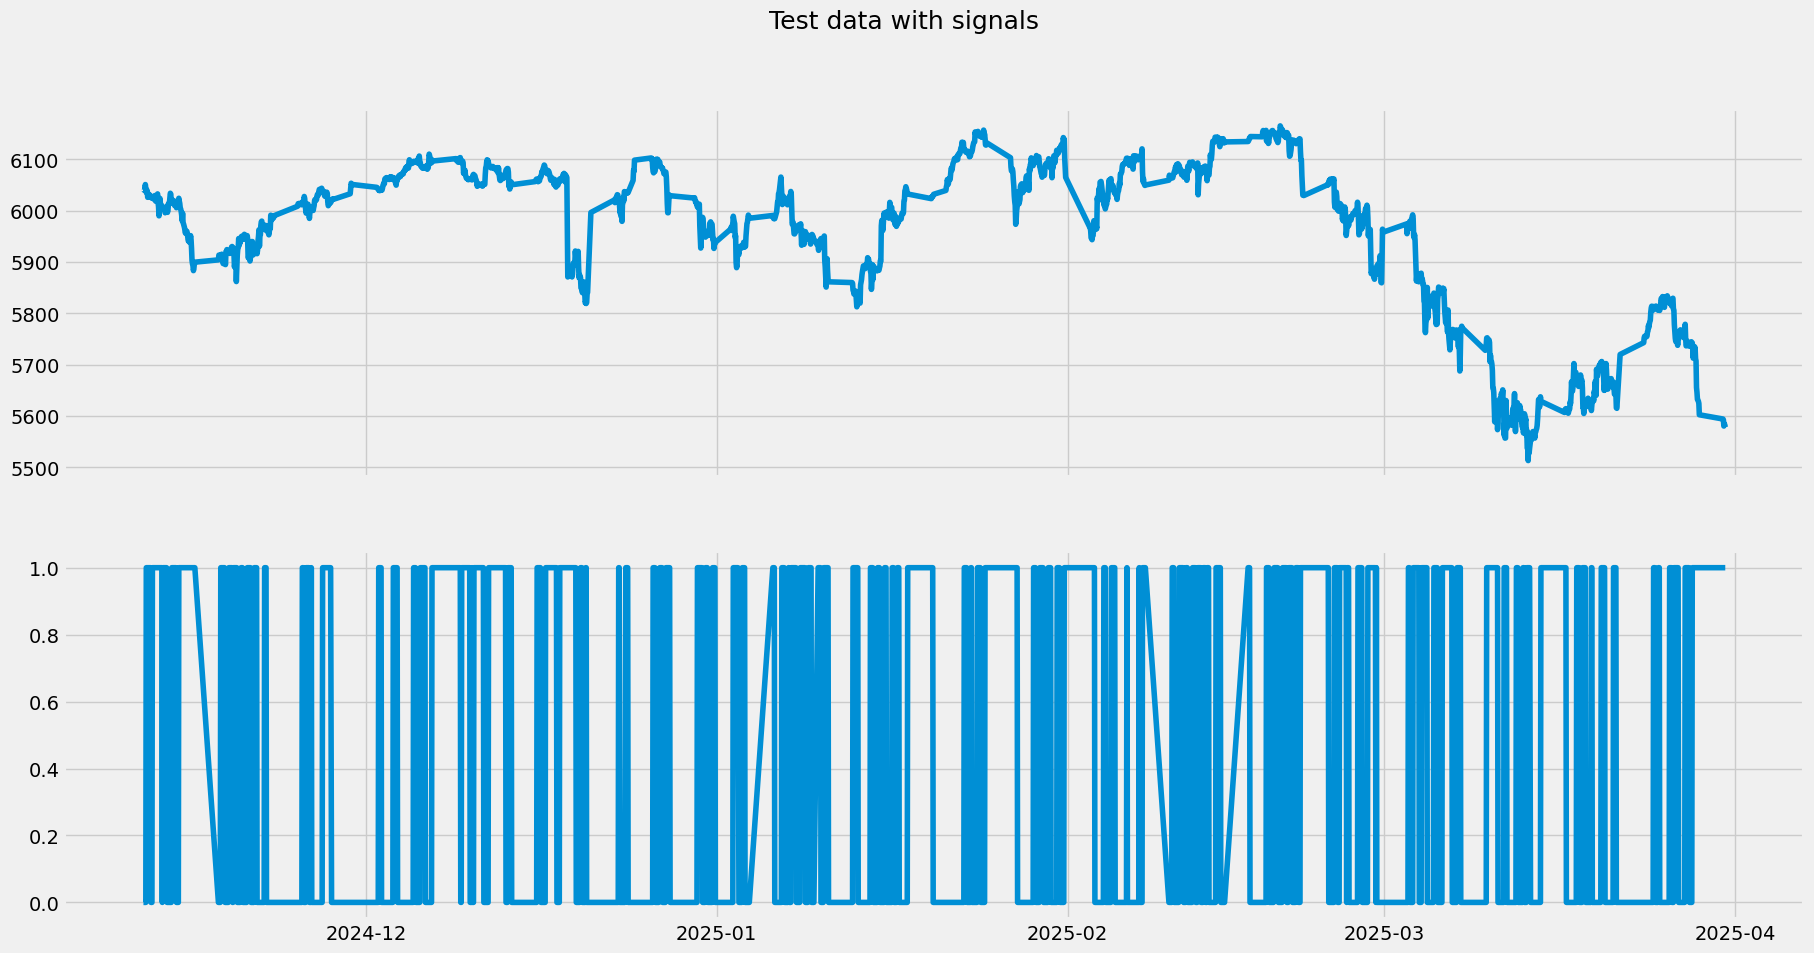

In [66]:
# plot predictions
df1 = df.Close[-(len(Xtest)-seqlen):]
fig, axs = plt.subplots(2, sharex=True, figsize=(20,10))
fig.suptitle('Test data with signals', size=18)
axs[0].plot(df1.index, df1)
axs[1].plot(df1.index, ypred);

In [67]:
# load model - os.path.abspath(model_path)
model = load_model(results_path / 'model.h5')

# summarize model
model.summary()

# evaluate the model
score = model.evaluate(g_, verbose=0)
print(f'{model.metrics_names[1]}, {score[1]*100:.4}%')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM1 (LSTM)                         │ (None, 21, 20)              │           7,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drouput1 (Dropout)                   │ (None, 21, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM2 (LSTM)                         │ (None, 21, 10)              │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drouput2 (Dropout)                   │ (None, 21, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM3 (LSTM)                         │ (None, 10)                  │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,013 (39.12 KB)

 Trainable params: 10,011 (39.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

compile_metrics, 74.21%
